# Network Based Social Media Analytics
## Q Smart - 2306288s
### Github: https://github.com/axqs/web_sci_ae
### Sample data is available in the sample.csv file on github.

----

## Contents
1. [Introduction](#intro)
1. [Data Crawl](#data_crawl)
  1. [Streaming](#stream)
  1. [REST Probing](#rest)
1. [Group Tweets](#grouping)
  1. [Tweet Clustering](#group)
  1. [Cluster Statistics](#stats)
1. [Capture and Organize User and Hashtag Information](#organize)
  1. [Organize User Information](#userinfo)
  1. [Organize Hashtag Information](#taginfo)
1. [Network Analysis](#analysis)

----

#### Toggle Code Cells

In [1]:
# Code in this cell is taken from John H. Williamson's 
# lecture notes for Data Fundamentals 2019
import IPython.display
IPython.display.HTML("""
    <script>
      function code_toggle() {
        if (code_shown){
          $('div.input').hide('500');
          $('#toggleButton').val('Show Code')
        } else {
          $('div.input').show('500');
          $('#toggleButton').val('Hide Code')
        }
        code_shown = !code_shown
      }

      $( document ).ready(function(){
        code_shown=false;
        $('div.input').hide()
      });
    </script>
    <form action="javascript:code_toggle()">
    <input type="submit" id="toggleButton" value="Show Code"></form>
""")

In [82]:
import pymongo
import tweepy
import os
import time
import copy

from datetime import datetime
from IPython.display import clear_output

import pandas as pd
from numpy import nan

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from jupyterthemes import jtplot
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

#mongodb access
password = os.environ["WEBSCI_MONGODB_PASS"]
client = pymongo.MongoClient("mongodb://qsmart:"+
                             password+
                             "@qs-web-science-ae-shard-00-00-4pdo2.mongodb.net:27017,"+
                             "qs-web-science-ae-shard-00-01-4pdo2.mongodb.net:27017,"+
                             "qs-web-science-ae-shard-00-02-4pdo2.mongodb.net:27017/"+
                             "test?ssl=true&replicaSet=qs-web-science-ae-shard-0"+
                             "&authSource=admin&retryWrites=true&w=majority")

#tweepy access
pk = os.environ["WEBSCI_PKEY"]
sk = os.environ["WEBSCI_SKEY"]
pt = os.environ["WEBSCI_PTOKEN"]
st = os.environ["WEBSCI_STOKEN"]

auth = tweepy.OAuthHandler(pk, sk)
auth.set_access_token(pt, st)

api = tweepy.API(auth)

print("Everything imported OK.")

Everything imported OK.


In [181]:
# users_df = pd.DataFrame()
# streamed_df = pd.DataFrame()
# rest_df = pd.DataFrame()

# to_dataframe: convert all tweet dicts into dataframes
# parameters: none
# return: none. global dataframe variables updated
#def to_dataframe():
users_df =  pd.DataFrame.from_dict(user_ids).T
streamed_df = pd.DataFrame.from_dict(streamed_tweets).T
rest_df = pd.DataFrame.from_dict(rest_tweets).T
    
# format_lists: format lists after converting from csv to dict
# parameters: dictionary to format
# return: formatted dictionary
def format_lists(dictionary):
    for k,v in dictionary.items():
        if v["hashtags"] != []:
            v["hashtags"] = str(v['hashtags']).split("'")[1:-1:2]
        else:
            v["hashtags"] = []
        if v["user_mentions"] != []:
            v["user_mentions"] = str(v['user_mentions']).split("'")[1:-1:2]
        else:
            v["user_mentions"] = []
    
    return dictionary

# from_csv: reads in tweet csv files as dataframes and converts dataframes to dictionaries
# parameters: none
# return: none. global tweet dicts are updated
def from_csv():
    users_df = pd.read_csv("users.csv")
    users_df = users_df.set_index('id')

    streamed_df = pd.read_csv("streamed.csv")
    streamed_df = streamed_df.set_index('tweet_id')

    rest_df = pd.read_csv("rest.csv")
    rest_df = rest_df.set_index('tweet_id')

    rest_tweets = rest_df.T.to_dict()
    streamed_tweets = streamed_df.T.to_dict()
    user_ids = users_df.T.to_dict()
    
    rest_tweets = format_lists(rest_tweets)
    streamed_tweets = format_lists(streamed_tweets)

# to_csv: convert all tweet dataframes into dictionaries
# parameters: none
# return: none. global tweet dicts variables updated
# def to_csv():
#     to_dataframe()
users_df.to_csv(r'users3.csv',header=True)
streamed_df.to_csv(r'streamed3.csv', header=True)
rest_df.to_csv(r'rest3.csv', header=True)

<a id="intro"></a>
# Introduction

This notebook contains code for developing a Twitter data crawler using Tweepy, the python library to access the Twitter streaming API. One percent of twitter data is collected using a streamer that filters tweets by certain keywords based on chosen topic or user. 

The data used in this notebook was collected on March 15, 2020 from 16:30 to 18:30 in order to provide the most recent data set. The data in the stream was filtered on the topic of Major League Baseball and the Astros cheating scandal of 2019 in which the Houston Astros baseball team, located in Houston, Texas, was accused and found guilty of cheating by sign stealing and wearing wires during postseason baseball games which, in turn, lead to them winning the World Series, baseball's championship series, in 2017. Tracked words were directly related to this topic, but because Tweepy's functionality does not allow for phrases or the tracking of a pair of words together, all tracked words were separated (ie. `"opening day"` became `"opening","day"`) and tweets were later filtered to remove any irrelevant tweets. Tracked words included hashtags such as `"astroscheated"` and `"houstonasterisks"`, and baseball team names such as `"yankees"` and `"astros"`. Streaming for a two hour period while tracking 39 words returned 359,864 unfiltered tweets that are then run through a filter to remove any unrelated data.

Data was also collected using Twitter's REST API as a second source for access to tweets. Tweets were found both by keyword and username, both pertaining to the subject of MLB. Popular hashtags were used as keywords and usernames chosen were based on personal knowledge of sports reporters and MLB verified accounts. Hashtags such as `"#TaintedTitle"` and `"#AsteriskTour"` were chosen as keywords and user accounts such as the MLB verified account, `"@MLB"`, and verified team accounts such as `"@Yankees"` and `"RedSox"` were used as well. Because tweets collected with the REST architecture come from sources and accounts that are heavily focused on the subject, these tweets do not need to be filtered further. Using the REST API across 68 usernames and seven hashtags, a total of 63,775 tweets were collected.

All tweets collected, both from streaming and REST, are then stripped of any noise data such as urls, user mentions, hashtags, and retweet symbols. These pieces of information are not necessary in the tweet as it is instead stored in the tweet's metadata and would result in inaccurate analysis of the tweets.

A corpus analysis is then performed on all tweets using Python's `SciKit` for clustering with it's `KMeans` algorithm. The top 20 words are taken from around each cluster epicenter. These words are then used to group the tweets into the relevant clusters. Statistics are then found on each cluster as well as all tweets, reporting on the number of tweets, likes, and retweets in each group as well as the average numbers across all tweets. The most used hashtags and the users with the most mentions are also reported for each cluster and across all tweets.

The metadata of each tweet is then analyzed on user mentions and hashtags used to create network graphs. The graphs of user mentions shows how users interact with eachother and which users interact the most and with whom they interact. The hashtag network graphs shows the relationship between hashtags and how often two tags will appear in the same tweet. These graphs are created for all clusters as well as across all tweets collected but because of the sheer amount of tweets, only select graphs are shown and there is a minimum number of connections required for a user or hashtag to be shown.

From these graphs, ties and triads are easy to identify within each collection. Ties are identified when one user mentions another or one hashtag appears in the same tweet as another hashtag. Triads are composed of three users that form a chain or circle of mentions, ofr example if user a mentions user b and user b mentions user c, a triad is formed between users a, b, and c and the triad is closed if user c mentions user a. Within the hashtags networks, two hashtags that are linked together by another form a triad. If a tweet contains `#MLB` and `#SpringTraining`, and another tweet contains `#SpringTraining` and `#OpeningDay`, `#MLB`, `#SpringTraining`, and `#OpeningDay` form a triad. The triad is complete if another tweet contains `#MLB` and `#OpeningDay`. Information on the number of ties and triads in each cluster is given, along with the total number of ties and triads among all tweets.

In [3]:
# neatly prints a dictionary object
def pretty_print(d, indent=0):
    for key,value in d.items():
        
        # print the indent, and then the key
        print(" "*indent,key,":", end=' ')

        # check if it's a dictionary: if so, recursive call
        if type(value)==type({}):
            print()
            pretty_print(value, indent+4)

        # if it's a list, print a comma separated sequence
        elif type(value)==type([]):
            print(", ".join(str(x) for x in value))
        else:
            
            # just a plain value
            print(value)

In [4]:
# filter_user_info: adds a user to dictionary of all users, user_ids, 
#                   only storing relevant user data
# parameters: The dictionary parameter is the user dictionary part of 
#             a tweet retrieved using the Twitter API
# return: the screen name of the user just added
def filter_user_info(dictionary):
    
    #if user already exists in dictionary
    try:
        user_ids[dictionary["screen_name"]]["count"] += 1
        
    #if user does not exist
    except KeyError:
        tweet_user = {}
        
        # list to filter relevant user information
        user_info = ["name","screen_name","verified","location",
                     "followers_count","friends_count","favourites_count"]
        
        for j in user_info:
            tweet_user[j] = dictionary[j]
        tweet_user["count"] = 1
        
        #add new user to dictionary
        user_ids[dictionary["screen_name"]] = tweet_user
        
    # returns screen name of user
    return dictionary["screen_name"]

In [166]:
# filter_tweet_info: adds a tweet to the streamed_tweets dictionary, 
#                    only storing relevant tweet information
# parameters: The dictionary parameter is the user dictionary part of 
#             a tweet retrieved using the Twitter API
# return: a dictionary of the filtered tweet information
def filter_tweet_info(dictionary):
    filtered_info = {}
    
    # list of relevant tweet information to filter
    tweet_info = ["created_at","user",
                  "extended_tweet","hashtags","user_mentions",
                  "in_reply_to_screen_name","retweeted_status",
                  "is_quote_status",
                  "retweet_count","favorite_count","quote_count","reply_count",]
    for j in tweet_info:
        if j == "user":
            filtered_info[j] = filter_user_info(dictionary["user"])
        else:
            try:
                # if "extended_tweet in dictionary, get full text. 
                # otherwise, get regular text"
                if j == "extended_tweet":
                    try:
                        filtered_info["text"] = dictionary["extended_tweet"]["full_text"]
                    except KeyError:
                        filtered_info["text"] = dictionary["text"]
                        
                # if tweet is a retweet, get the id of the user retweeted, 
                # otherwise set value to False
                elif j == "retweeted_status":
                    try:
                        filtered_info["retweeted_status"] = dictionary["retweeted_status"]["user"]["screen_name"]
                        try:
                            filtered_info["text"] = dictionary["retweeted_status"]["extended_tweet"]["full_text"]
                        except:
                            filtered_info["text"] = dictionary["retweeted_status"]["text"]
                    except KeyError:
                        filtered_info["retweeted_status"] = False

                # get any and all hashtags in tweet 
                elif j == "hashtags":
                    filtered_info["hashtags"] = []
                    for h in dictionary["entities"]["hashtags"]:
                        filtered_info["hashtags"].append(h["text"])
                
                # get any and all user mentions in tweet 
                elif j == "user_mentions":
                    filtered_info["user_mentions"] = []
                    for h in dictionary["entities"]["user_mentions"]:
                        filtered_info["user_mentions"].append(h["screen_name"])
                else:
                    filtered_info[j] = dictionary[j]
                    
            except KeyError:
                filtered_info[j] = 0
                
    # returns dictionary of filtered tweet information
    return filtered_info

<a id="data_crawl"></a>
# Data Crawl

<a id="stream"></a>
## Twitter Streaming

Initial data was streamed for an hour between 16:11 and 17:11 on Saturday March 7, 2020. The final data referenced and shown in this report was streamed for two hours between 16:30 and 18:30 Sunday March 15 2020 to get the most accurate and recent data.

The inherited class `TwitterStreamer` takes a stream listener and overrides the parent `on_status` function to retrieve a tweet from the stream, filter it through the `filter_tweet_info` function and add it to the dictionary of tweets accessed from streaming, `streamed_tweets`. The `filter_tweet_info` function takes the raw status.\_json from the streamer and filteres out any unnecessary data, only retaining the creation date, the user who posted it, the full text of the tweet, all hashtags and user mentions as two lists, the name of the user replying to, if there is one, the retweet and quote status, and favorite, retweet, reply, and quote counts. For each tweet filtered, the user account information is also filtered and placed in the `user_ids` dictionary which stores relevant information on the user's name and screen name, verified status, location, and friends, followers, and favorites counts.

Each time a tweet is retrieved from the stream, the `streamTimer` function is called to ensure that the time the stream has been active does not exceed the two hour mark. Once the two hours has passed, the stream is disconnected and the start time and finish time are printed to the console along with the tracked words and number of tweets collected.

In [168]:
# streamTimer: check that stream has run for an allotted amount of time
# parameters: none
# return: none. Prints tracking and streaming statistics to console
def streamTimer():
    currentTime = time.time()
    
    # check to see if hour has passed, 3600 seconds = 1 hr
    # check to see if hour has passed, 7200 seconds = 2 hr
    if(currentTime - startTime >= 7200):
        
        # clears the output of the cell
        clear_output()
        
        # print stream statistics
        print("Tracking: "+str(tracking))
        
        # dicsonect stream
        print("Disconnecting stream . . .")
        stream.disconnect()
        print("Stream disconnected.")
        
        print("Stream started at: ",startStream)
        print("Collected:",len(streamed_tweets))
        print("Stream ended at: ",datetime.now().strftime("%m/%d/%Y, %H:%M:%S"))
        

class TwitterStreamer(tweepy.StreamListener):
    def on_status(self, status):
        
        # Filter the tweet and then add it to the streamed_tweets 
        # dictionary with the key being the tweet_id
        streamed_tweets[status._json["id"]] = filter_tweet_info(status._json)
        streamed_tweets[status._json["id"]]["tweet_id"] = status._json["id"]
        
        # print tweet text and how many tweets collected so far
        print(status.text)
        print("-"*100,"Collected:",len(streamed_tweets))
        
        # Check to see if allotted time, in this case 2 hours, has passed
        streamTimer()
        
    def on_error(self,status_code):
        print(status_code)
        return False

In [7]:
streamed_tweets = {}
user_ids = {}

# create listener
listener = TwitterStreamer(api=tweepy.API(auth,
                           wait_on_rate_limit=True, 
                           wait_on_rate_limit_notify=True))
# create streamer
stream = tweepy.Stream(auth=auth, listener=listener)

# keywords to track
tracking = []

startStream = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
startTime = time.time()

# stream_tweets: starts streaming twitter data
# parameters: none
# return: none. Prints all tweet text as they are processed
def stream_tweets():
    
    # words to look for and track in tweets, subject: MLB and the Astros Cheating Scandal
    tracking = [
        "baseball","mlb","Major","League",
        "world","series","spring","training","opening","day",
        "yankees","houston","astros","dodgers","los","angeles","angels",
        "chicago","cubs","tampa","bay","rays","red","sox","la","tb",
        "cheated","scandal","asterisks","sign","stealing",
        "cheating",'statcast','ai','scouting'
        "astroscheated","astrosscandal","houstonasterisks","astroscheatingscandal",
    ]

    print("Tracking: "+str(tracking))
    
    # start timer for stream
    startTime = time.time()
    startStream = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    print("Stream started at: ",startStream)
    
    # filter stream on keywords
    stream.filter(track=tracking, languages=['en'], is_async=True)

In [169]:
# stream_tweets()
print("Tweets acquired by streaming:",len(streamed_tweets))


Tracking: ["baseball","mlb","Major","League","Baseball","world","series","spring","training","opening","day","yankees","houston","astros","dodgers","los","angeles","angels","chicago","cubs","tampa","bay","rays","red","sox","la","tb","cheated","scandal","asterisks","sign","stealing","cheating","scandal",'statcast','ai','scouting'"astroscheated","astrosscandal","houstonasterisks","astroscheatingscandal"]
Disconnecting stream . . .
Stream disconnected.
Stream started at:  03/15/2020, 16:30:43
Collected: 359864
Stream ended at:  03/15/2020, 18:30:43

Tweets acquired by streaming: 359864


<a id="rest"></a>
## REST Architecture

The two functions `getTweetsByUsername` and `getTweetsByKeywords` utilize Tweepy's REST API to search for tweets that may not have been found using the streamer. This hybrid use of technology allows for greater coverage of the Twitter universe and gives more accurate access to information on a certain topic.

The `getTweetsByUsername` takes a twitter username as a parameter and finds the 1,000 latest tweets by said user, not inluding retweets, filters the tweets, and adds them to the `rest_tweets` dictionary and adds the user to the `user_ids` dictionary. The `getTweetsByKeywords` function takes a list of keywords as a parameter and iterates through each word and finds all tweets over the past year that contain the keyword. These tweets are also added to the `rest_tweets` dictionary and their users added to `user_ids`.

The `rest` function initializes both a list of keywords to search and a list of usernames to access. It then calls the `getTweetsByKeywords` and passes the list of keywords as the argument. After all keywords are searched, it loops through each username in the list and calls the `getTweetsByUsername` function on each one. Once the tweets for the specific name or word have been found, the function prints the keyword and username to the console and displays information on how many tweets were found using the REST API.

In [49]:
# getTweetsByUsername: get 1000 most recent tweets from specific user
# parameters: twitter username to probe
# return: none. global dictionary rest_tweets is updated
def getTweetsByUsername(name):
    try:
        api.get_user(name)
        print(name,end=" ")
    
        # get user timeline
        timeline = tweepy.Cursor(api.user_timeline, screen_name=name, count=200, 
                                 lang="en", include_rts=False, 
                                 wait_on_rate_limit=True).items(1000)

        tweepy.Cursor(api.search, lang="en", count=100, until="").items(1000)
        for item in timeline:
            filter_tweet = filter_tweet_info(item._json)

            # add tweet to dictionary
            rest_tweets[item._json["id"]] = filter_tweet
    except:
        return

In [50]:
# getTweetsByKeywords: get all tweets with specific words within the past year
# parameters: list of keywords to search for
# return: none. global dictionary rest_tweets is updated
def getTweetsByKeywords(words):
    print("Getting tweets with:",end=" ")
    for word in words:
        print(word,end=" ")
        
        # probe for specific word
        timeline = tweepy.Cursor(api.search, q=word, count=200, since="2019-01-01", 
                                 until="2020-03-15", wait_on_rate_limit=True).items()
        for item in timeline:
            filter_tweet = filter_tweet_info(item._json)
            
            # add tweet to rest_tweets dictionary
            rest_tweets[item._json["id"]] = filter_tweet

In [51]:
rest_tweets = {}

# rest_probing: defines key words and users and searches them
# parameters: none
# return: none
def rest():
    
    # keywords to look for 
    keywords = ["#astroscheated","#astrosscandal","#houstonasterisks",
                "#StripTheTitle","#TaintedTitle","#AsteriskTour","#AstrosCheatingScandal"]
    
    # Usernames to retrieve
    mlb_official_accounts = ['fastballs', 'Bill_TPA', 'LAAngelsPR', 'Rockies', 
     'RangerBlake',"Buster_ESPN",'Ken_Rosenthal', 'Phillies', 'Marlins', 
     'Indians', 'zacharylevine', 'Brewers', 'astros', 'TwinsPrez', 'joe_sheehan', 
     'Mariners', 'Rockies', 'Cubs', 'Athletics', 'Yankees', 'RedSox', 'jazayerli', 
     'RaysBaseball', 'Nationals', 'Twins', 'Angels', 'cwyers', 'str8edgeracer', 
     'Mets', 'jonmorosi', 'jay_jaffe', 'Padres', 'YankeesPR', 'Reds', 'Dbacks', 
     'tigers', 'hangingsliders', 'LookoutLanding', 'Dodgers', 'DanEvans108', 'Braves',
     'AnswerDave', 'MLB', 'BronxPinstripes', "ChristinaKahrl","MLB_PLAYERS","MLBPAA",
     'ProfessorParks', 'LoMoMarlins', 'MLBReports', 'keithlaw', 'OldHossRadbourn',
     'BMcCarthy32', 'SamMillerBB', 'MLBDepthCharts','michael_schlact', 'Kevin_Goldstein', 
     'bryceharper3', 'NoahSyndergaard','MarcCarig','whitesox','Cardinals',
     'SFGiants','BlueJays','Rangers','Orioles','Pirates','Royals',
    ]
    
    # REST get keywords
    getTweetsByKeywords(keywords)
    
    #REST get users
    print("\nGetting tweets by:",end=" ")
    for i in mlb_official_accounts:
        getTweetsByUsername(i)
    print("\nDone.")

In [54]:
#rest()

streamed_copy = copy.deepcopy(streamed_tweets)
rest_copy = copy.deepcopy(rest_tweets)
users_copy = copy.deepcopy(user_ids)

print("Tweets found by REST probing:",len(rest_tweets))


Getting tweets with: #astroscheated #astrosscandal #houstonasterisks #StripTheTitle #TaintedTitle #AsteriskTour #AstrosCheatingScandal 
Getting tweets by: fastballs Bill_TPA LAAngelsPR Rockies RangerBlake Buster_ESPN Ken_Rosenthal Phillies Marlins Indians zacharylevine Brewers astros TwinsPrez joe_sheehan Mariners Rockies Cubs Athletics Yankees RedSox jazayerli RaysBaseball Nationals Twins Angels cwyers str8edgeracer Mets jonmorosi jay_jaffe Padres YankeesPR Reds Dbacks tigers hangingsliders LookoutLanding Dodgers DanEvans108 Braves AnswerDave MLB BronxPinstripes ChristinaKahrl MLB_PLAYERS MLBPAA ProfessorParks LoMoMarlins MLBReports keithlaw OldHossRadbourn BMcCarthy32 SamMillerBB MLBDepthCharts michael_schlact Kevin_Goldstein bryceharper3 NoahSyndergaard MarcCarig whitesox Cardinals SFGiants BlueJays Rangers Orioles Pirates Royals 
Done.

Tweets found by REST probing: 63775


<a id="grouping"></a>
# Group Tweets

In order to properly analyze the set of collected tweets, tweets that have been accessed through streaming must be properly filtered. Because the streaming capabilities bo not extend to phrases comprised of more than one word, all tweets that are not on the chosen topic must be removed in order to properly and accurately analyze the data. This is done using the `filter_documents` function which takes the dictionary of tweets to be filtered as a parameter. The streamed tweets are then checked against a list of phrases that the tweet must contain. If the tweet does not contain any of these phrases, it is removed from the collection.

After the tweets are filtered, the text has to then be stripped to remove any noise words such as urls, user mentions, hashtags, and retweet symbols. If these are not removed, the corpus analyzer reads them as regular words and the data would be heavily skewed. Following this process, the `rest_tweets` and `streamed_tweets` are combined into one dictionary, `all_tweets` for ease of analysis. The number of streamed documents, rest documents, filtered streamed documents, and total documents is reported.

In [55]:
# strip_documents: filter text of tweets to remove any noise words
# parameters: dictionary of tweets
# return: dictionary of tweets with filtered text
def strip_documents(dictionary):
    
    # filter tweet text to remove any links, mentions, 
    # hashtags, retweets, and noise before clustering
    for k,v in dictionary.items():
        i = v["text"]
        split_words = i.strip().split()
        filtered_line = []
        for s in split_words:
            if "http" not in s.lower() and "@" not in s.lower() and "#" not in s.lower() and "rt" not in s.lower():
                filtered_line.append(s)
        filtered_line = " ".join(filtered_line)
        dictionary[k]["text"] = filtered_line
    
    return dictionary

# filter_documents: filter streamed documents to only include words 
#                   in a certain context, in this case baseball terms
# parameters: dictionary of tweets
# return: dictionary with only relevant tweets
def filter_documents(dictionary):
    filtered_dict = {}
    phrases = [
        "baseball","mlb","Major League Baseball",
        "world series","spring training","opening day",
        "yankees","astros","dodgers","los angeles angels",
        "chicago cubs","tampa bay rays","red sox","la angels","tb rays",
        "astros cheated","astros scandal","houston asterisks",
        "sign stealing","astros cheating scandal",'statcast ai','scouting',
        "astroscheated","astrosscandal","houstonasterisks","astroscheatingscandal",
    ]
    
    for k,v in dictionary.items():
        count = 0;
        text = v["text"]
        for p in phrases:
            if p.lower() in text.lower():
                count += 1
                
        # if tweet contains any of the phrases in the list, add it to filtered dict
        if count > 0:
            filtered_dict[k] = v
    
    return filtered_dict

In [57]:
# filter_tweets: filter streamed tweets and strip streamed and rest tweets
# parameters: none
# return:dictionary of combined rest and streamed tweets in one dictionary
def filter_tweets():
    combined_tweets = {}
    
    # strip streamed tweets
    documents = strip_documents(streamed_tweets)
    print(len(documents),"streamed documents",len(rest_tweets),"rest documents")
    
    # filter streamed tweets
    filtered = filter_documents(documents)
    print(len(filtered),"filtered streamed documents")
    
    #add filtered streamed tweets and stripped rest tweets into combined_tweets dict
    combined_tweets = filtered.copy()
    combined_tweets.update(strip_documents(rest_tweets))
    
    print(len(combined_tweets),"total documents")
    
    return combined_tweets

all_tweets = filter_tweets()

359864 streamed documents 63775 rest documents
4381 filtered streamed documents
68155 total documents


<a id="group"></a>
## Tweet Clustering

Tweets are grouped together using Python's `SciKit` package and it's `sklearn.cluster.KMeans` methods to cluster the text in the tweets. A `k=20` was used in this instance as it produced the most suitable clusters. The `cluster` function takes in a piece of text, in this case a list of strings, and an optional k-value as it's parameters. The text variable is generated by taking the text from every tweet object in the combined tweets dictionary, `all_tweets`, and adding it to a list. The function then provides information on the length of the text and the number of groups generated. The KMeans model is computed and the top 20 words in each cluster are returned as a list of lists.

After the `word_clusters` are created, a new dictionary is formed, `clustered_tweets`, which contains 20 subsequent dictionaries, one for each cluster. Each nested dictionary contains all tweets that contain a word in the relevant word cluster. For example, `clustered_tweets[0]` holds all tweets that contain any word in `word_clusters[0]`. Each cluster's top 20 words are then printed and the clusters are saved to an external file for security and recreation purposes.

In [58]:
# cluster: use scikit to cluster all_tweets using kmeans
# parameters: list of sentences to be clustered
# return: list of lists, each list is the top 20 words in the cluster for each cluster
def cluster(text,true_k=20):
    clusters = []
    
    # compute inverse document frequency (word frequency) across all sentences
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(text)
    print(len(text),"tweets, ",end="")
    print(true_k,"groups.")
    
    # compute KMeans with true_km in this case 20, groups
    model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=1)
    model.fit(X)
    
    # get top 20 words in each cluster, add them (as a list) 
    # to clusters list, and print them out
    top_terms = 20
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    
    print("Top",top_terms,"terms per cluster:")
    for i in range(true_k):
        print ("Cluster:", i+1)
        clusters.append([])
        for ind in order_centroids[i, :top_terms]:
            print(terms[ind],end=", ")
            clusters[i].append(terms[ind])
        print("\n")
        
    return clusters

In [59]:
texts = []

# get list of all tweets' text
for k,v in all_tweets.items():
    texts.append(v["text"])
word_clusters = cluster(texts)

# write all clusters to a text file
with open("clusters.txt","w") as f:
    for words in range(len(word_clusters)):
        f.write("Cluster: "+str(words+1)+"\n")
        f.write(", ".join(word_clusters[words])+"\n\n")

68155 tweets, 20 groups.
Top 20 terms per cluster:
Cluster: 1
leaderboard, tuned, blast, joining, running, stay, coming, final, thanks, today, expand, 𝟻𝟶, exp, exotic, exorcism, exits, exited, expanded, expanding, expandin, 

Cluster: 2
day, roster, rhp, updated, opening, optioned, 10, game, today, recalled, il, following, yankees, rp, placed, moves, sp, triple, prior, inf, 

Cluster: 3
owned, daily, hitter, nl, al, pitcher, 2018, 2019, baseball, mvp, mvps, 2017, august, july, september, june, april, 2016, 28, 25, 

Cluster: 4
browse, attended, 1969, program, brought, dc, member, th, fun, amp, game, expected, expecting, exorcism, exotic, exp, expand, expanded, expandin, expanding, 

Cluster: 5
good, luck, morning, pretty, looking, baseball, day, season, really, today, game, looks, like, feels, oh, thanks, great, think, news, things, 

Cluster: 6
lineup, tonight, today, vs, game, pitch, series, 05, pregame, 05pm, preview, finale, ct, cf, angels, road, stream, final, halos, yes, 

Cluste

In [60]:
clustered_tweets = {}

# tweets_contain_word: searches all_tweets dictionary and 
#                      collects tweets that contain a specific word
# parameters: string word to search for
# return: dictionary of all tweets containing specific word
def tweets_contain_word(word):
    tweets_with_word = {}
    
    for k,v in all_tweets.items():
        
        # if the tweet's text contains the word, add it to the tweets_with_word dict
        if word.lower() in v["text"].lower():
            tweets_with_word[k] = v
            
    return tweets_with_word

# get_tweet_clusters: for each cluster, find all tweets containing 
#                     any of the top 20 words in that cluster
# parameters: none
# return: none. updates global clustered_tweets dictionary
def get_tweet_clusters():      
    for cluster in range(len(word_clusters)):
        
        # get list of words in each cluster
        words = word_clusters[cluster]
        clustered_tweets[cluster] = {}
        for word in words:
            
            # get all tweets with specific word
            word_tweets = tweets_contain_word(word)
            
            # only add to dict if there are more than 10 tweets containing the word
            if len(word_tweets) > 10:
                clustered_tweets[cluster].update(word_tweets)

get_tweet_clusters()

<a id="stats"></a>
## Cluster Statistics

Each cluster in then analyzed and reports on the most popular hashtags and user mentions are displayed, along with the number of total tweets, user mentions, hashtags, favorites, and retweets within a group. These statistics are also calculated across all tweets and displayed. Data on all clusters is presented along with the statistics across each group. This data shows the total number of groups, the average number of tweets in a group, and the minimim and maximum group sizes.

In [61]:
# get_hashtags_and_usermentions_count: finds top 20 hashtags used and users 
#                                      mentioned in the tweet dictionary given
# parameters: dictionary to present stats on
# return: none. prints hashtag and user mention stats to console
def get_hashtags_and_usermentions_count(dictionary,top=20):
    hashtags = {}
    mentions = {}
    for k,v in dictionary.items():
        
        # count number of times hashtag across all tweets in dict
        if( v["hashtags"] != []):
            for tag in v["hashtags"]:
                
                # if hashtag is already in dict, increase count
                try:
                    hashtags[tag] += 1
                    
                # if hashtag not in dict set count to 1
                except:
                    hashtags[tag] = 1
        
        # count number of times user is mentioned across all tweets in dict
        if( v["user_mentions"] != []):
            for user in v["user_mentions"]:
                
                # if user is already in dict, increase count
                try:
                    mentions[user] += 1
                    
                # if hashtag not in dict set count to 1
                except:
                    mentions[user] = 1            
                    
    # top is minimim value between the hashtags, mentions, and specified number
    top = min(top,len(hashtags),len(mentions))
    
    print("   {:>12}  {:>7}  {:>12}".format("Number of Hashtags Used: "+
                                            str(len(hashtags)),"","Number of Users Mentioned: "+
                                            str(len(mentions))))
    
    print("   {:>12}  {:>20}  {:>12}".format("Top "+
                                             str(top)+" Hashtags:", "","Top "+
                                             str(top)+" User Mentions:"))
    
    # sort hashtags and user mentions from most to least appearances
    sorted_tags = sorted(hashtags.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
    sorted_mentions = sorted(mentions.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
    
    # print top hashtags and mentions
    for i in range(top):
        t = sorted_tags[i]
        m = sorted_mentions[i]
        print("   {:<40s}{:>4s}".format("  "+
                                        t[0]+": "+
                                        str(t[1]),"  "+
                                        m[0]+": "+
                                        str(m[1])))

# group_stats: finds number of tweets, likes, and retweets total in a tweet dictionary
# parameters: dictionary to present stats on
# return: none. prints found stats to console
def group_stats(dictionary):
    likes = 0
    retweets = 0
    for k,v in dictionary.items():
        
        # get likes and retweet counts from each tweet and increase total
        likes += v["favorite_count"]
        retweets += v["retweet_count"]
        
    print("   Total Number of Tweets:",len(dictionary))
    print("   Total Number of Favorites:",likes)
    print("   Total Number of Retweets:",retweets)

# group_sizes: get statistics on all tweets collected and get averages across all groups
# parameters: none
# return: none. prints found stats to console
def group_sizes():
    sizes = []
    print("   Number of Groups:",len(clustered_tweets))
    
    # get size of all clusters
    for k,v in clustered_tweets.items():
        sizes.append(len(v))
    
    # present stats in all clusters
    print("   Average Group Size:",int(sum(sizes)/len(sizes)))
    print("   Minimum Group Size:",min(sizes))
    print("   Maximum Group Size:",max(sizes))

# get_each_cluster: returns statistics and hashtag and 
#                   user mention information for each cluster
# parameters: none
# return: none. prints found stats to console
def get_each_cluster():
    for k,v in clustered_tweets.items():
        print("Cluster",k+1)
        
        # get stats for each cluster
        group_stats(v)
        print()
        
        # get hashtag and mentions stats in each cluster
        get_hashtags_and_usermentions_count(v,5)
        print()

In [62]:
print("All Tweet Statistics:")
group_stats(all_tweets)
get_hashtags_and_usermentions_count(all_tweets)

All Tweet Statistics:
   Total Number of Tweets: 68155
   Total Number of Favorites: 41631878
   Total Number of Retweets: 7311986
   Number of Hashtags Used: 2958           Number of Users Mentioned: 18687
   Top 20 Hashtags:                        Top 20 User Mentions:
     MLB: 586                                MLB: 844
     Angels: 583                             joelspishock_26: 560
     SFGiants: 483                           Twins: 403
     ThisIsMyCrew: 472                       JeffPassan: 374
     Yankees: 439                            MLBNetwork: 359
     MNTwins: 435                            KenBurns: 347
     AlwaysRoyal: 361                        PBS: 340
     TakeItBack: 313                         Yankees: 273
     PadresST: 274                           astros: 238
     ChopOn: 271                             octonion: 198
     Birdland: 247                           baseballhall: 172
     Brewers: 245                            TheAthleticMLB: 172
     AstrosChea

In [63]:
print("Cluster Statistics:")
group_sizes()
print()
get_each_cluster()

Cluster Statistics:
   Number of Groups: 20
   Average Group Size: 20636
   Minimum Group Size: 6364
   Maximum Group Size: 40950

Cluster 1
   Total Number of Tweets: 6364
   Total Number of Favorites: 3785491
   Total Number of Retweets: 638331

   Number of Hashtags Used: 536           Number of Users Mentioned: 2568
   Top 5 Hashtags:                        Top 5 User Mentions:
     Angels: 210                             Yankees: 81
     TrueToTheBlue: 177                      MLB: 76
     Cubs: 70                                YESNetwork: 71
     ThisIsMyCrew: 66                        Twins: 51
     RedSox: 61                              swbrailriders: 36

Cluster 2
   Total Number of Tweets: 23206
   Total Number of Favorites: 11369307
   Total Number of Retweets: 2196681

   Number of Hashtags Used: 1222           Number of Users Mentioned: 6055
   Top 5 Hashtags:                        Top 5 User Mentions:
     MLB: 504                                joelspishock_26: 560
  

   Number of Hashtags Used: 1785           Number of Users Mentioned: 9616
   Top 5 Hashtags:                        Top 5 User Mentions:
     MLB: 530                                joelspishock_26: 560
     Angels: 414                             MLB: 407
     MNTwins: 234                            KenBurns: 347
     ThisIsMyCrew: 233                       PBS: 340
     Yankees: 207                            JeffPassan: 321

Cluster 17
   Total Number of Tweets: 9524
   Total Number of Favorites: 5776245
   Total Number of Retweets: 1062617

   Number of Hashtags Used: 572           Number of Users Mentioned: 2354
   Top 5 Hashtags:                        Top 5 User Mentions:
     MLB: 476                                joelspishock_26: 560
     WOB: 194                                Yankees: 126
     ThisIsMyCrew: 144                       MLB: 118
     MNTwins: 99                             swbrailriders: 76
     Brewers: 95                             koordell: 47

Cluster 18


<a id="organize"></a>
# Capture and Organize User and Hashtag Information

The `get_user_connections` function is used to find all users and the people that they have mentioned or who have mentioned them. It takes a dictionary of tweets as a parameter and returns a dictionary of all users who have tweets in the aforementioned dictionary. This connection dictionary is of the structure `{user:[mention1, mention2]}` and is used as the format for dictionary parameters used in `get_edges`, `build_network_graph`, and `remove_empty`. 

The function `remove_empty` takes a connections dictionary in and removes any entry who's value is an empty list. The `get_edges` function takes a connections dictionary and a boolean unique to determine whether or not the edges in the returned list are unique (ie. \[a,b\] == \[b,a\]). The function returns a list of tuples that act as the edges in a network graph. This function is called inside the `build_network_graph` which uses Python's `networkx` package to build these network graphs. The list returned in the `get_edges` function is iterated over to create the edges and nodes for the graph. To view the graph, the function `show_graph` can be called with the graph to view and the desired color of the nodes.

In [69]:
# get_edges: get all edges in a dictionary of connections
# parameters: dictionary of connections to search, optional unique 
#             to specify no duplicates in different order
# return: list of all edges
def get_edges(connections,unique=False):
    edges = []
    
    # connections format {'username/hashtag':['usernames/hashtags','connected','to']}
    for k,v in connections.items():
        for name in v:
            try:
                # if user is in name's list and name in user's list 
                if k in connections[name]:
                    if unique:
                        # if unique dont include reversed edge as different
                        if [k,name] not in edges and [name,k] not in edges:
                            edges.append([k,name])
                    else:
                        if [k,name] not in edges:
                            edges.append([k,name])
            
            # if user is not in name's list, dont add edge
            except:
                continue
                
    return edges

# build_network_graph: builds network graph of all connections in given dictionary
# parameters: dictionary of connections, 
#             optional min_connections to specify how many connections 
#             a node has before it can appear in graph
# return: a networkx type Graph of all connections in dictionary
def build_network_graph(connections,min_connections=1):
    graph = nx.Graph()
    
    # get all unique edges
    edges = get_edges(connections,True)
    
    #list of all edges as one long list
    edges_list = " ".join([" ".join(i) for i in edges]).strip().split(" ")
    to_remove = []

    for name in connections.keys():
        
        # if name doesnt appear min_connections times in edges_list, dont add it as an edge
        if edges_list.count(name) <= min_connections:
            to_remove.append(name)
            
    users = []
    for edge in edges:
        # if edge is valid add it to graph and add each end of edge to users
        if edge[0] not in to_remove and edge[1] not in to_remove:
            graph.add_edge(edge[0], edge[1])
            if edge[0] not in users:
                users.append(edge[0])
            if edge[1] not in users:
                users.append(edge[1])
    
    # make all users nodes in graph
    # gets rid of any users with no connections or less than min_connections connections
    for user in users:
        graph.add_node(user)
    
    return graph

In [70]:
# remove_empty: removes any dictionary entry that is empty
# parameters: dictionary to modify
# return: filtered dictionary
def remove_empty(dictionary):
    users = [i for i in dictionary.keys()]
    for u in users:
        
        # remove dictionary entry if it is empty
        if dictionary[u] == []:
            del dictionary[u]
            
    return dictionary

# get_user_connections: returns a dictionary of all connections in a dictionary of tweets
# parameters: dictionary to search
# return: dictionary of all user connections in tweet set
def get_user_connections(dictionary):
    user_mention_info = {}
    
    # initialize all users in dict with empty list
    for i in user_ids.keys():
        user_mention_info[i] = []
    
    # every time user is mentioned or user is mentioned by someone else, 
    # add do relevand user's list
    for k,v in dictionary.items():
        uname = v["user"]
        if(v["user_mentions"] != []):
            for mention in v["user_mentions"]:
                if mention in user_mention_info.keys() and mention != uname:
                    if mention not in user_mention_info[uname]:
                        user_mention_info[uname].append(mention)
    
    # remove any empty dictionary entries
    user_mention_info = remove_empty(user_mention_info)
    
    return user_mention_info

all_user_connections = get_user_connections(all_tweets)

In [121]:
# show_graph: view network graph
# parameters: graph to plot, color of nodes for graph
# return: none. graph prints to screen
def show_graph(graph, color):
    if list(graph.nodes) == []:
        print("Graph Nodes:",RT_G.nodes)
        print("Graph Edges:",RT_G.edges)
        print("No graph to show")
    else:
        figure(figsize=(20, 20))
        nx.draw(graph, with_labels=True,node_size=0,font_color=color,font_weight="bold")
        plt.show()

<a id="userinfo"></a>
## Organize User Information

User network graphs have been split into two subsections, verified users and unverified users. As the number of users stored is too large to fit on one graph readably this split was necessary for viewing and analysis purposes and is done through the `get_verified_and_unverified` function which returns a tuple of verified and unverified user connection dictionaries. The same thing is done with both retweets and quote/reply tweets through the `get_retweets_and_quotetweets` function which returns a tuple of retwees and quote tweets user connection dictionaries. Both functions take a connections dictionary as the parameter. Displayed below is the verified users interaction graph and the quote tweets interaction graph.

In [122]:
# get_verified_and_unverified: splits connections dict into verified 
#                              and unverified user connections
# parameters: connections dictionary to split
# return: dictionary of verified users and their connections, dictionary 
#         of unverified users and their connections
def get_verified_and_unverified(connections):
    verified = {}
    unverified = {}
    
    # initialise users in verified and unverified dicts with empty lists
    for k in connections.keys():
        if user_ids[k]["verified"] == True:
            verified[k] = []
        else:
            unverified[k] = []
    
    # only add users to verified[user] list if the mentioned user is also verified
    for v in verified.keys():
        mentioned_users = connections[v]
        for user in mentioned_users:
            if user in verified.keys():
                verified[v].append(user)
                
    # only add users to unverified[user] list if the mentioned user is also unverified
    for uv in unverified.keys():
        uv_mentioned_users = connections[uv]
        for uv_user in uv_mentioned_users:
            if uv_user in unverified.keys():
                unverified[uv].append(uv_user)
                
    # filter out empty lists
    verified = remove_empty(verified)
    unverified = remove_empty(unverified)
    
    return verified,unverified
                
verified,unverified = get_verified_and_unverified(all_user_connections)

In [123]:
# get_retweets_and_quotetweets: finds only retweets and quote/reply tweets in tweet set
# parameters: dictionary od tweets to split
# return: dictionary of olny tweets that are retweets, dictionary 
#         of only tweets that are quote/reply tweets
def get_retweets_and_quotetweets(dictionary):
    retweets = {}
    quote_tweets = {}
    for k,v in dictionary.items():
        
        # if tweet has been retweeted, add to retweets dict, and 
        # add retweeted user to user's user mentions
        if v["retweeted_status"] != False:
            retweets[k] = v
            if retweets[k]["user_mentions"] != []:
                retweets[k]["user_mentions"].append(v["retweeted_status"])
            else:
                retweets[k]["user_mentions"] = [v["retweeted_status"]]
        
        # if tweet is a quote or reply add it to quote_tweets dict
        if v["is_quote_status"] != False or str(v["in_reply_to_screen_name"]) != str(nan):
            quote_tweets[k] = v
            
    return retweets, quote_tweets

retweets, quoted = get_retweets_and_quotetweets(all_tweets)
retweet_connections = get_user_connections(retweets)
quoted_connections  = get_user_connections(quoted)

### Verified Users Interaction Graph

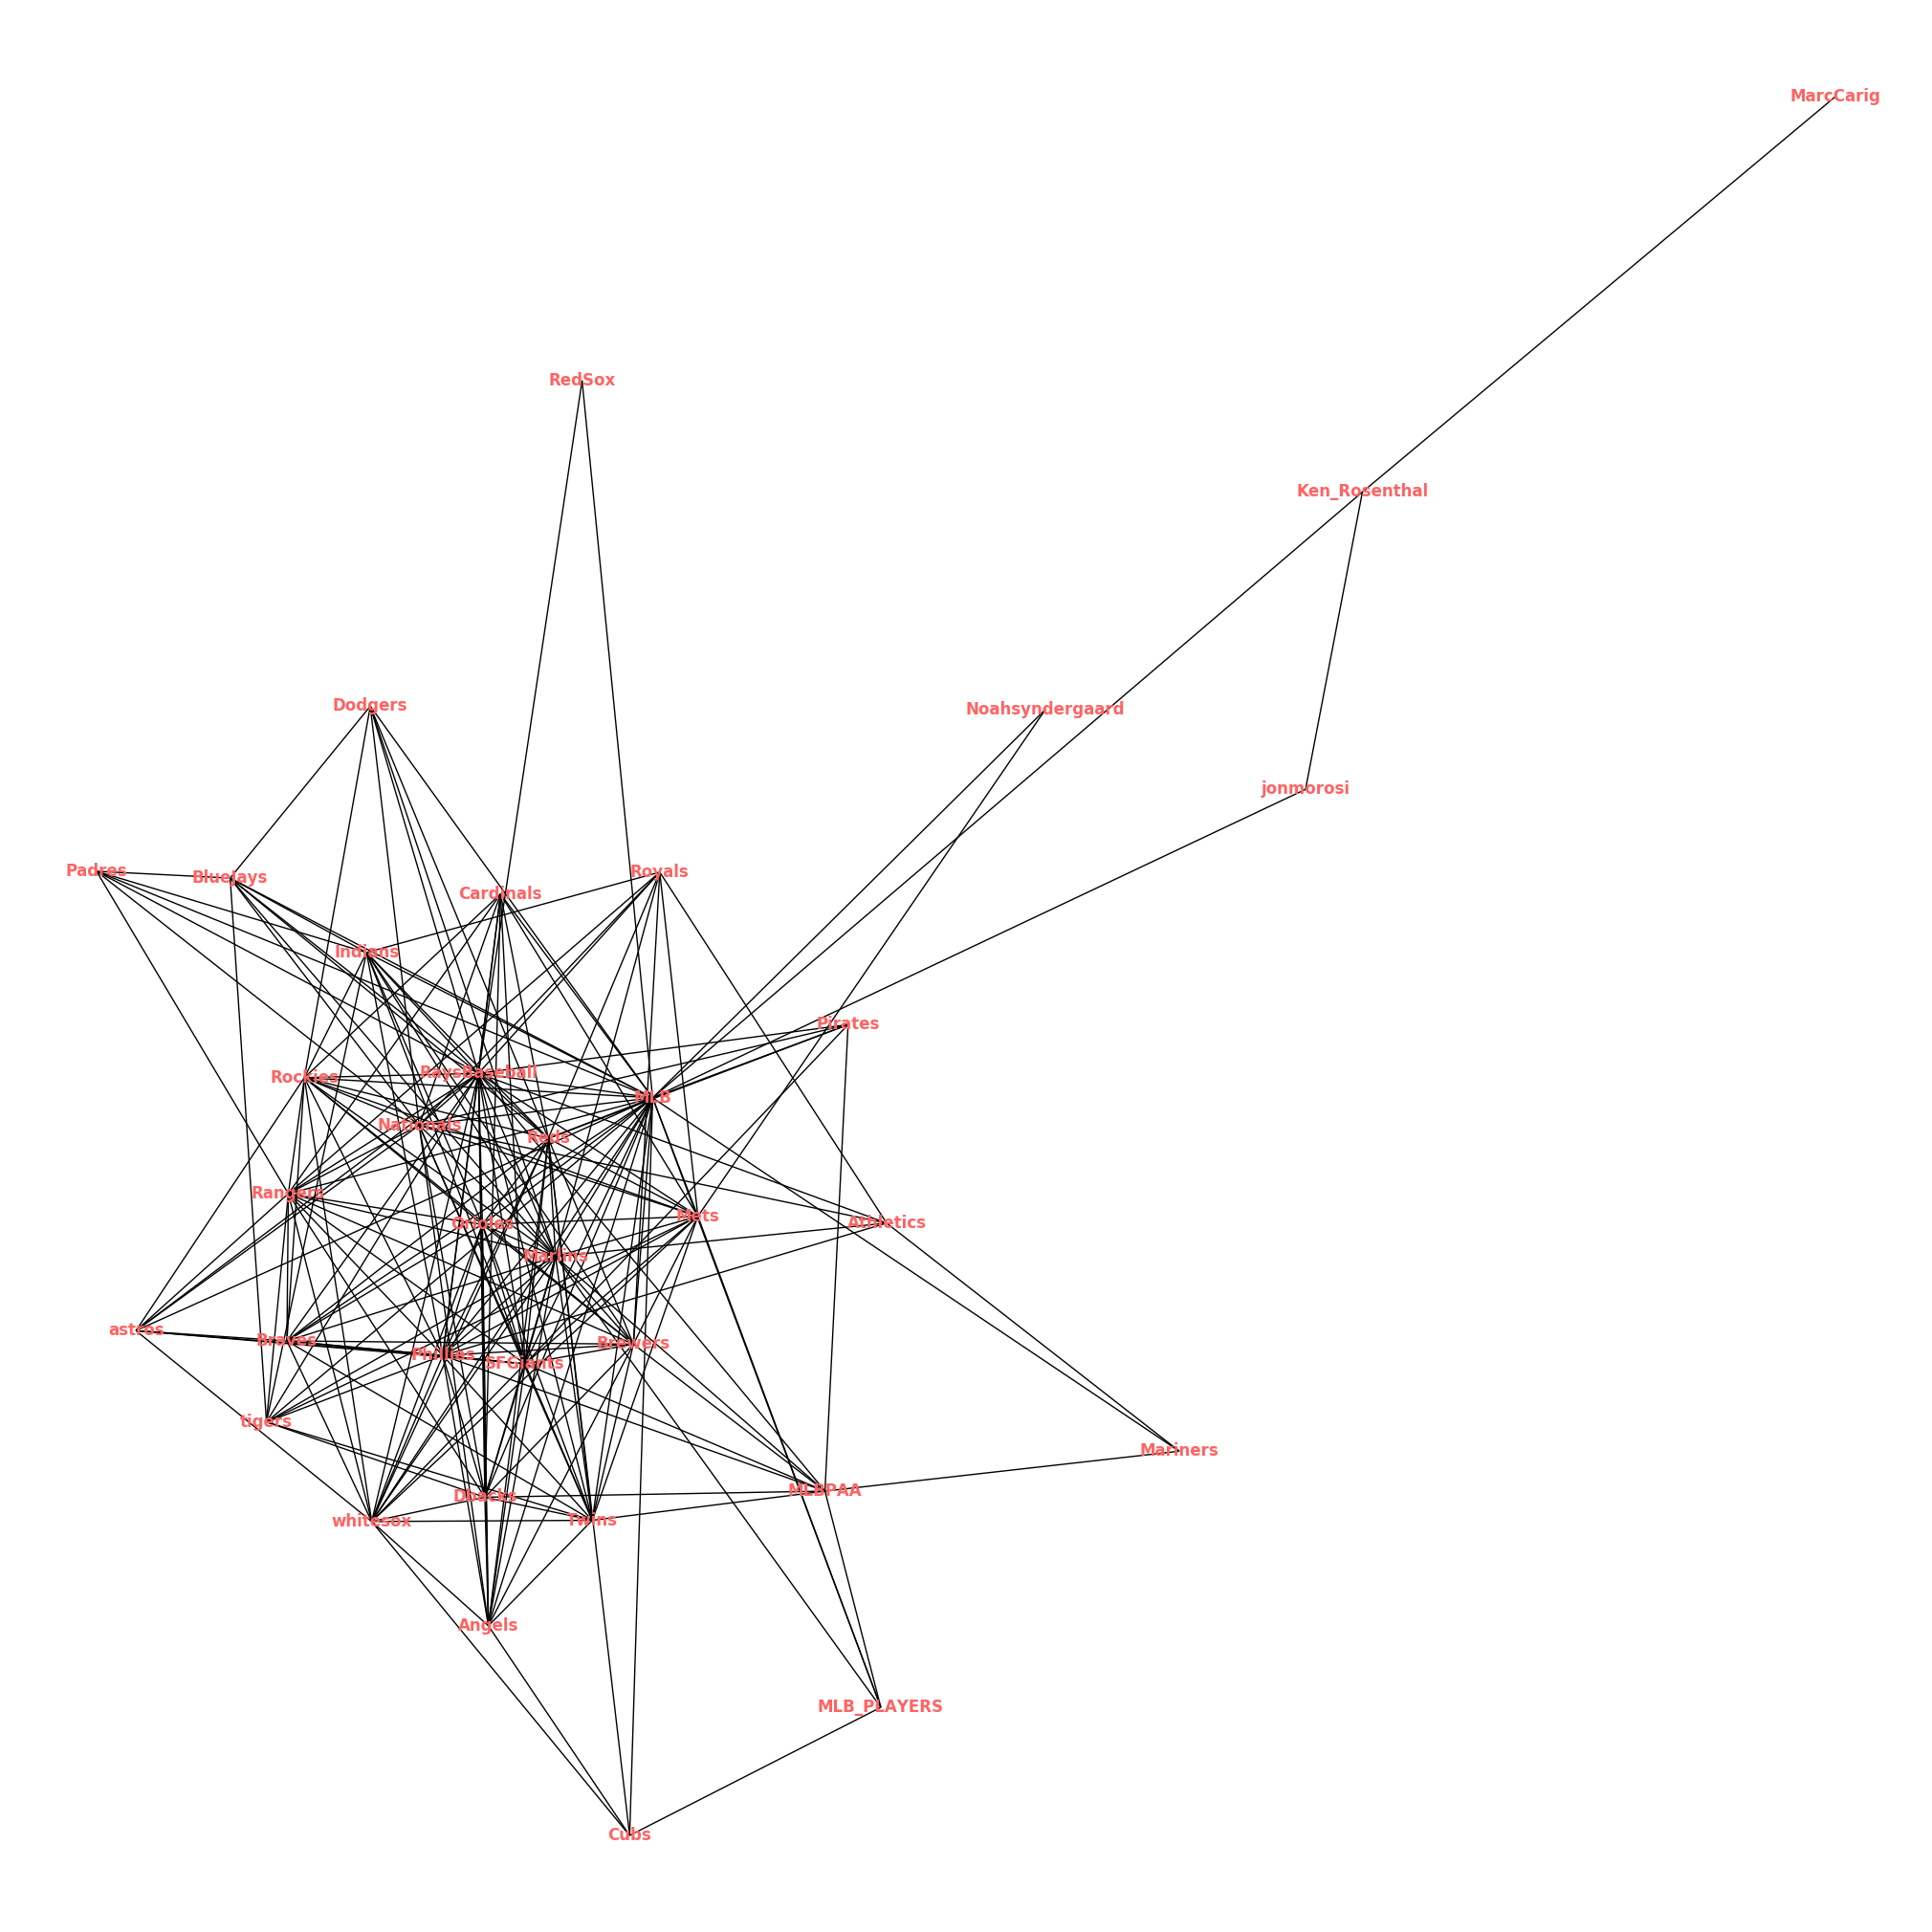

In [124]:
V_G = build_network_graph(verified)
show_graph(V_G,"#FF6363")

### Quote Tweets User Interaction Graph

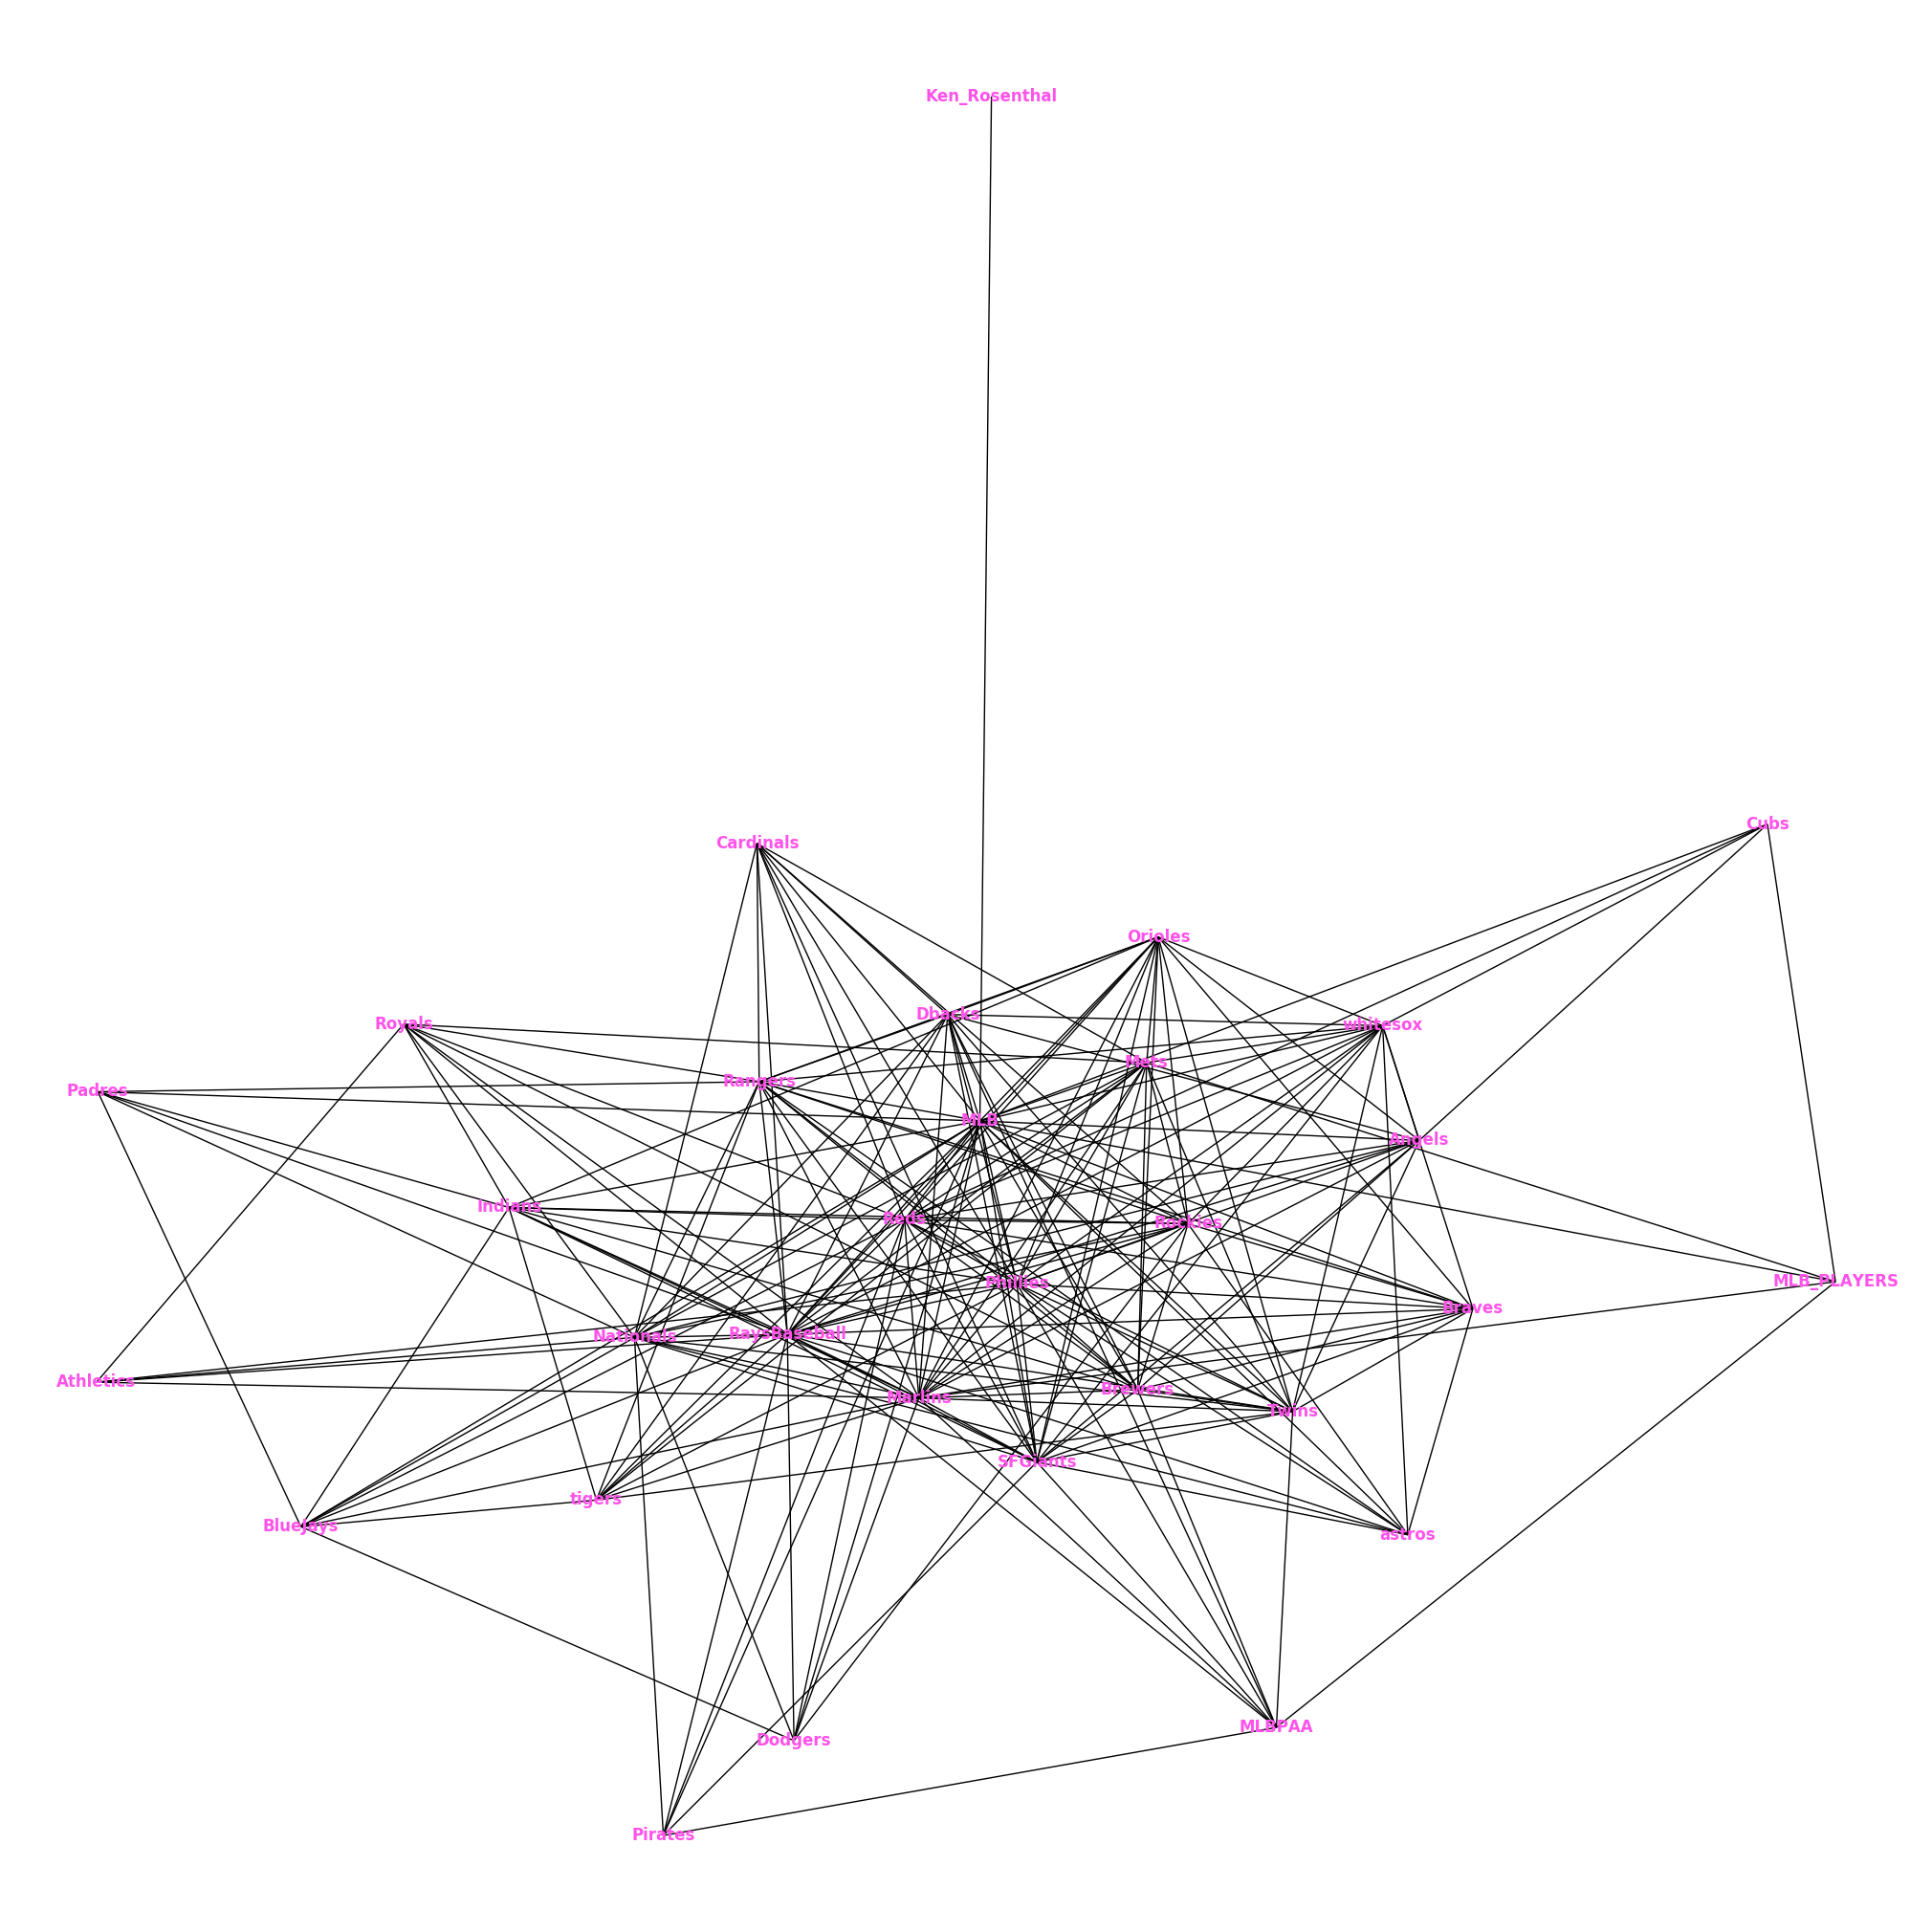

In [128]:
RT_G = build_network_graph(retweet_connections)
QT_G = build_network_graph(quoted_connections,4)

show_graph(QT_G,"#FF52EA")

### Clustrers User Interaction Graphs

The graphs for user connections within each group can be retrieved by calling `get_cluster_user_graphs` and passing the `clustered_tweets` dictionary as an argument. This function loops through each cluster of tweets and returns a list of user connections for each cluster as well as the built graph for each cluster. Shown below is the user network interactions graph for cluster 4.

In [126]:
# get_cluster_user_graphs: generates user mention graphs for 
#                          each cluster created in section 2
# parameters: dictionary of tweets to graph
# return: list of user connection dictionaries for each cluster, 
#         list of user graphs for each cluster
def get_cluster_user_graphs(dictionary):
    cluster_connections = []
    cluster_graphs = []
    
    # get all user connections for each cluster in dict
    for k,v in dictionary.items():
        connections = get_user_connections(v)
        cluster_connections.append(connections)
    
    # make network graphs for each user connections dict
    for connection in cluster_connections:
        graph = build_network_graph(connection)
        cluster_graphs.append(graph)
    
    return cluster_connections, cluster_graphs

user_cluster_connections, user_cluster_graphs = get_cluster_user_graphs(clustered_tweets)

#### Example Graph: Cluster 4 of 20

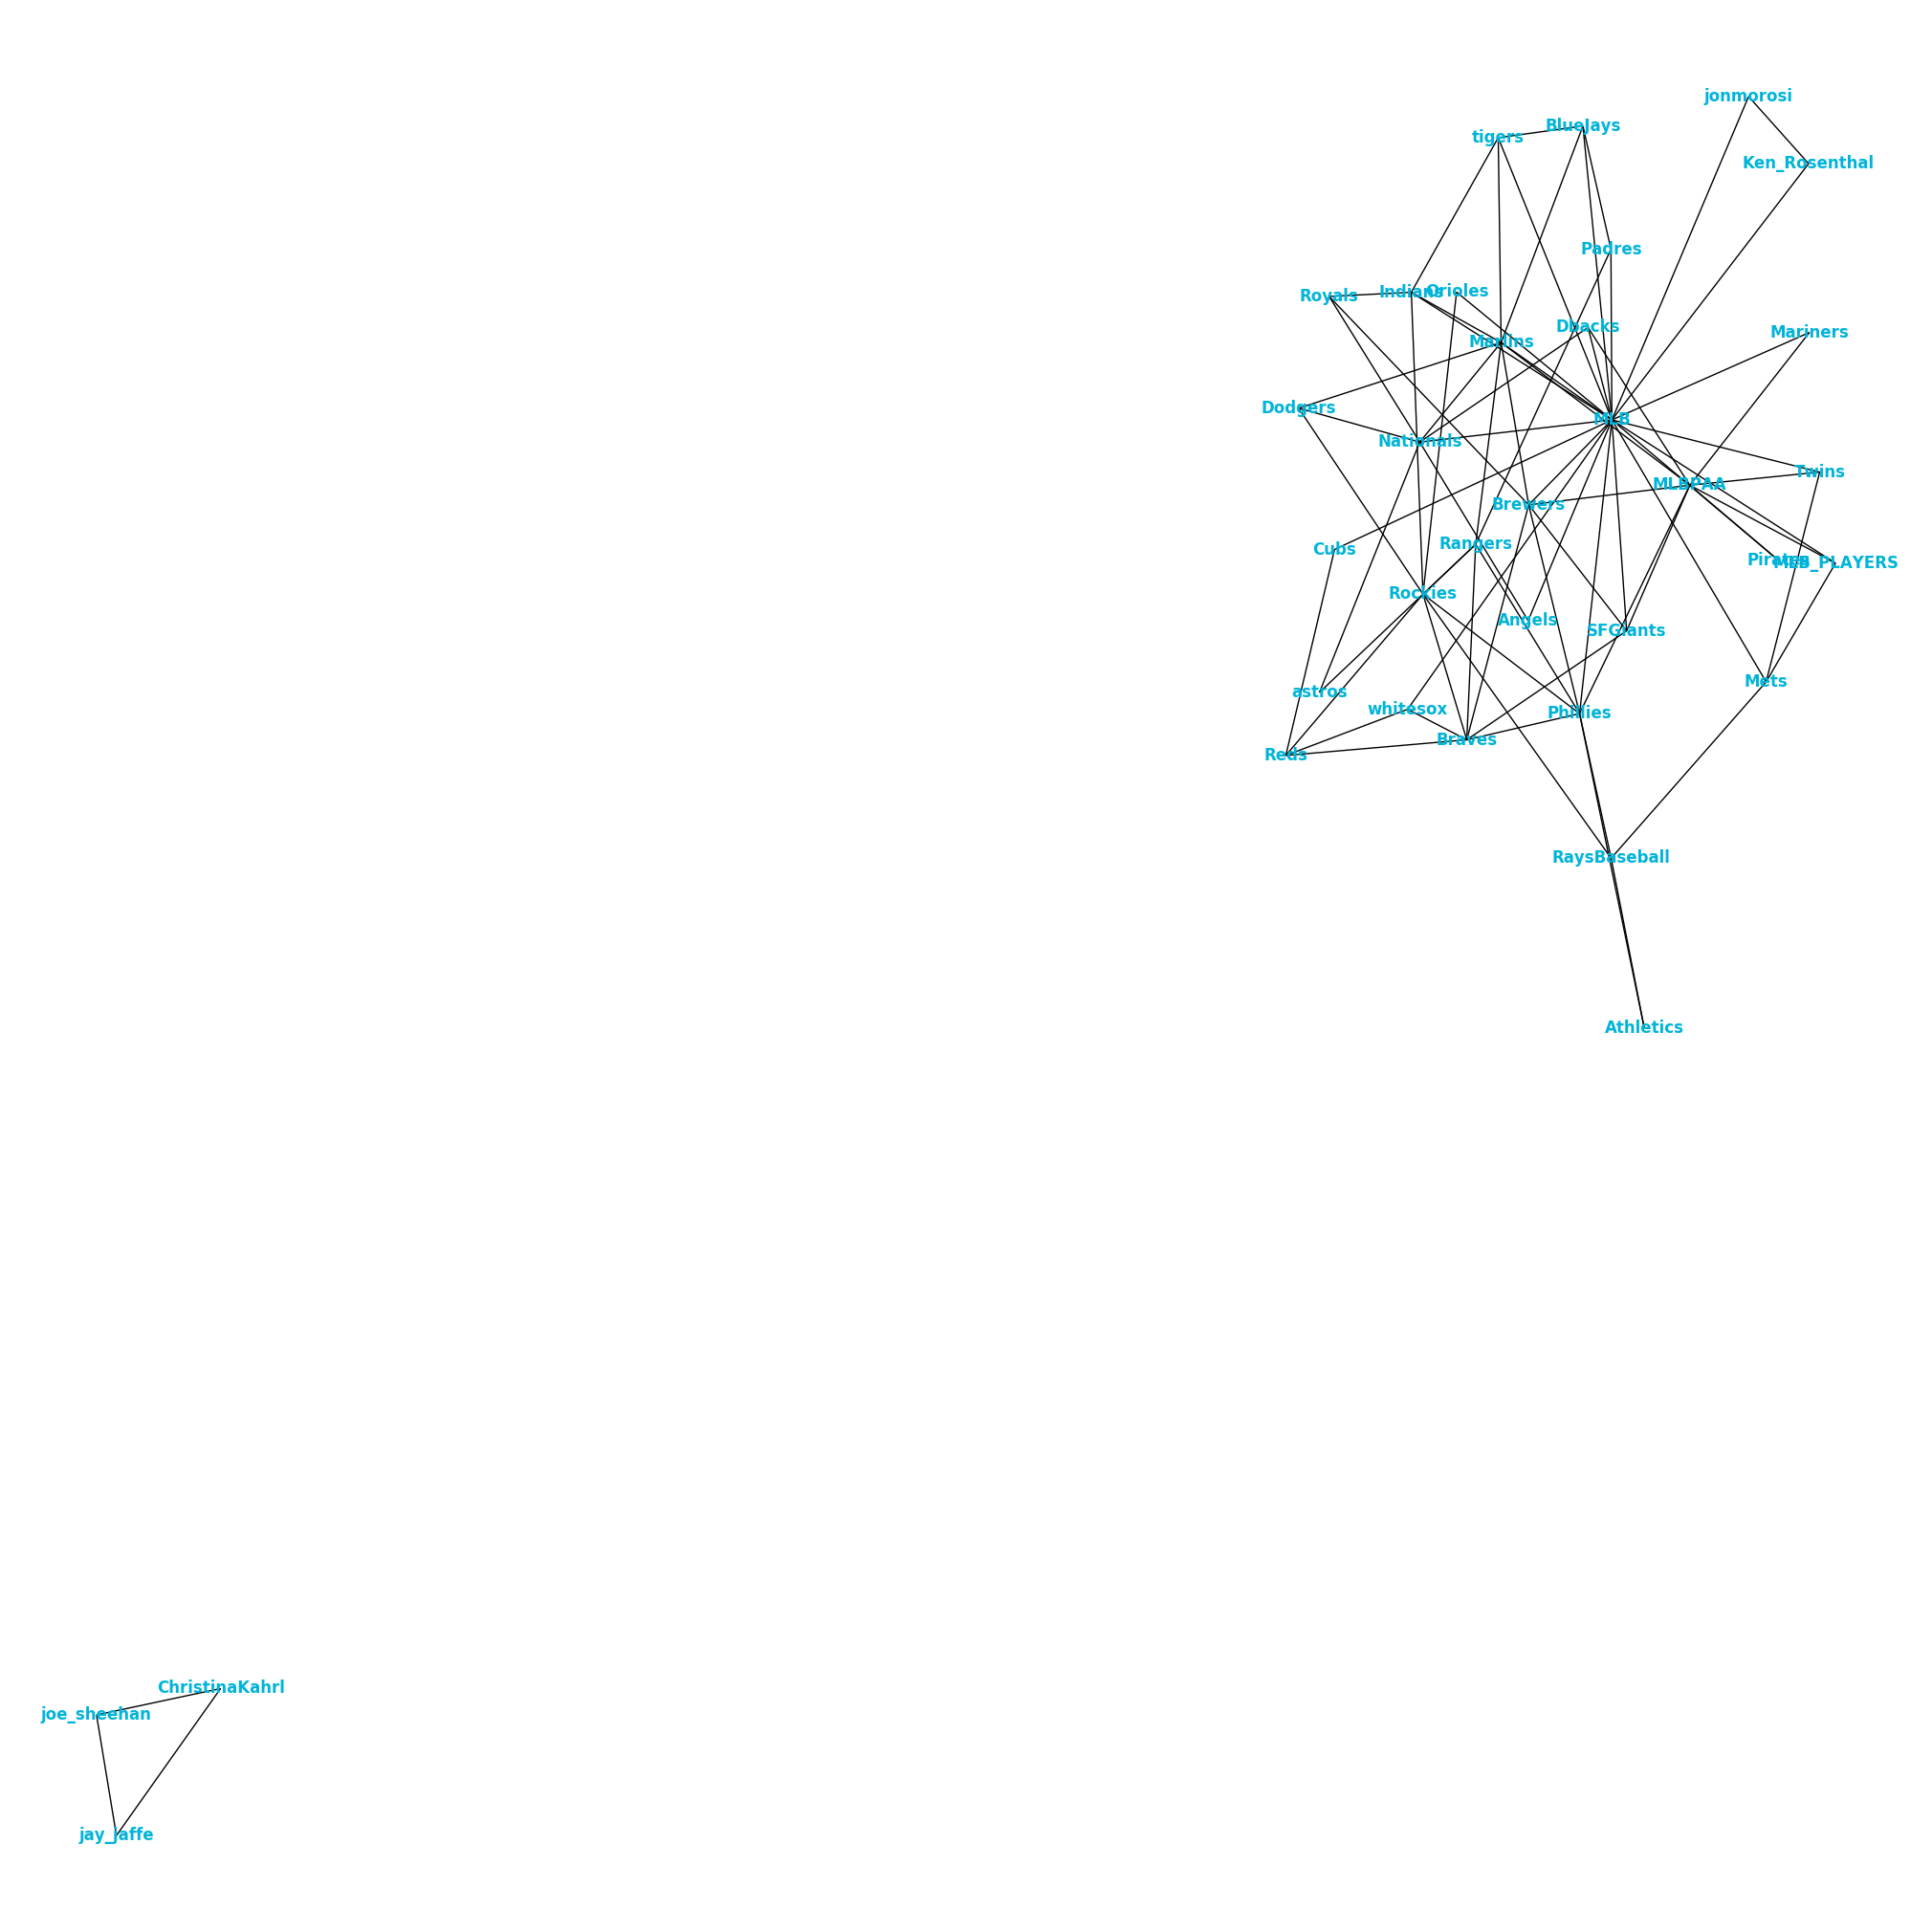

In [155]:
show_graph(user_cluster_graphs[3],"#00b4d9")

<a id="taginfo"></a>
## Organize Hashtag Information

Similarly to what was done in `get_user_connections`, the `get_hashtag_connections` function takes a dictionary of tweets to report on and returns a connections dictionary of all hashtags in that group of tweets. It records all hashtags in the tweet set and any other hashtags that they are mentioned with and stores it in a dictionary of the same structure. Below, a graph of the network of all hashtags that appear more than 10 times across all tweets.

In [130]:
# get_hashtag_connections: finds all hashtag connections in tweet set
# parameters: dictionary od tweets to search
# return: dictionary of all hashtag connections in given tweet set
def get_hashtag_connections(dictionary):
    hashtag_mentions = {}
    
    for k,v in dictionary.items():
        
        # if hashtags are mentioned in tweet, add them and their connections to dict
        if v["hashtags"] != []:
            for t in v["hashtags"]:
                for tag in v["hashtags"]:
                    # if hashtag already in dict, continue. else add to dict with empty list
                    try:
                        tags = hashtag_mentions[t]
                    except:
                        hashtag_mentions[t] = []
                        
                    # if tag isnt already in mention's list and tag is not itself, 
                    # add it to list
                    if tag != t and tag not in hashtag_mentions[t]:
                        hashtag_mentions[t].append(tag)
                        
    # remove any empty entries from dict
    hashtag_mentions = remove_empty(hashtag_mentions)
    return hashtag_mentions

hashtag_connections = get_hashtag_connections(all_tweets)

### All Hashtags Interaction Graph

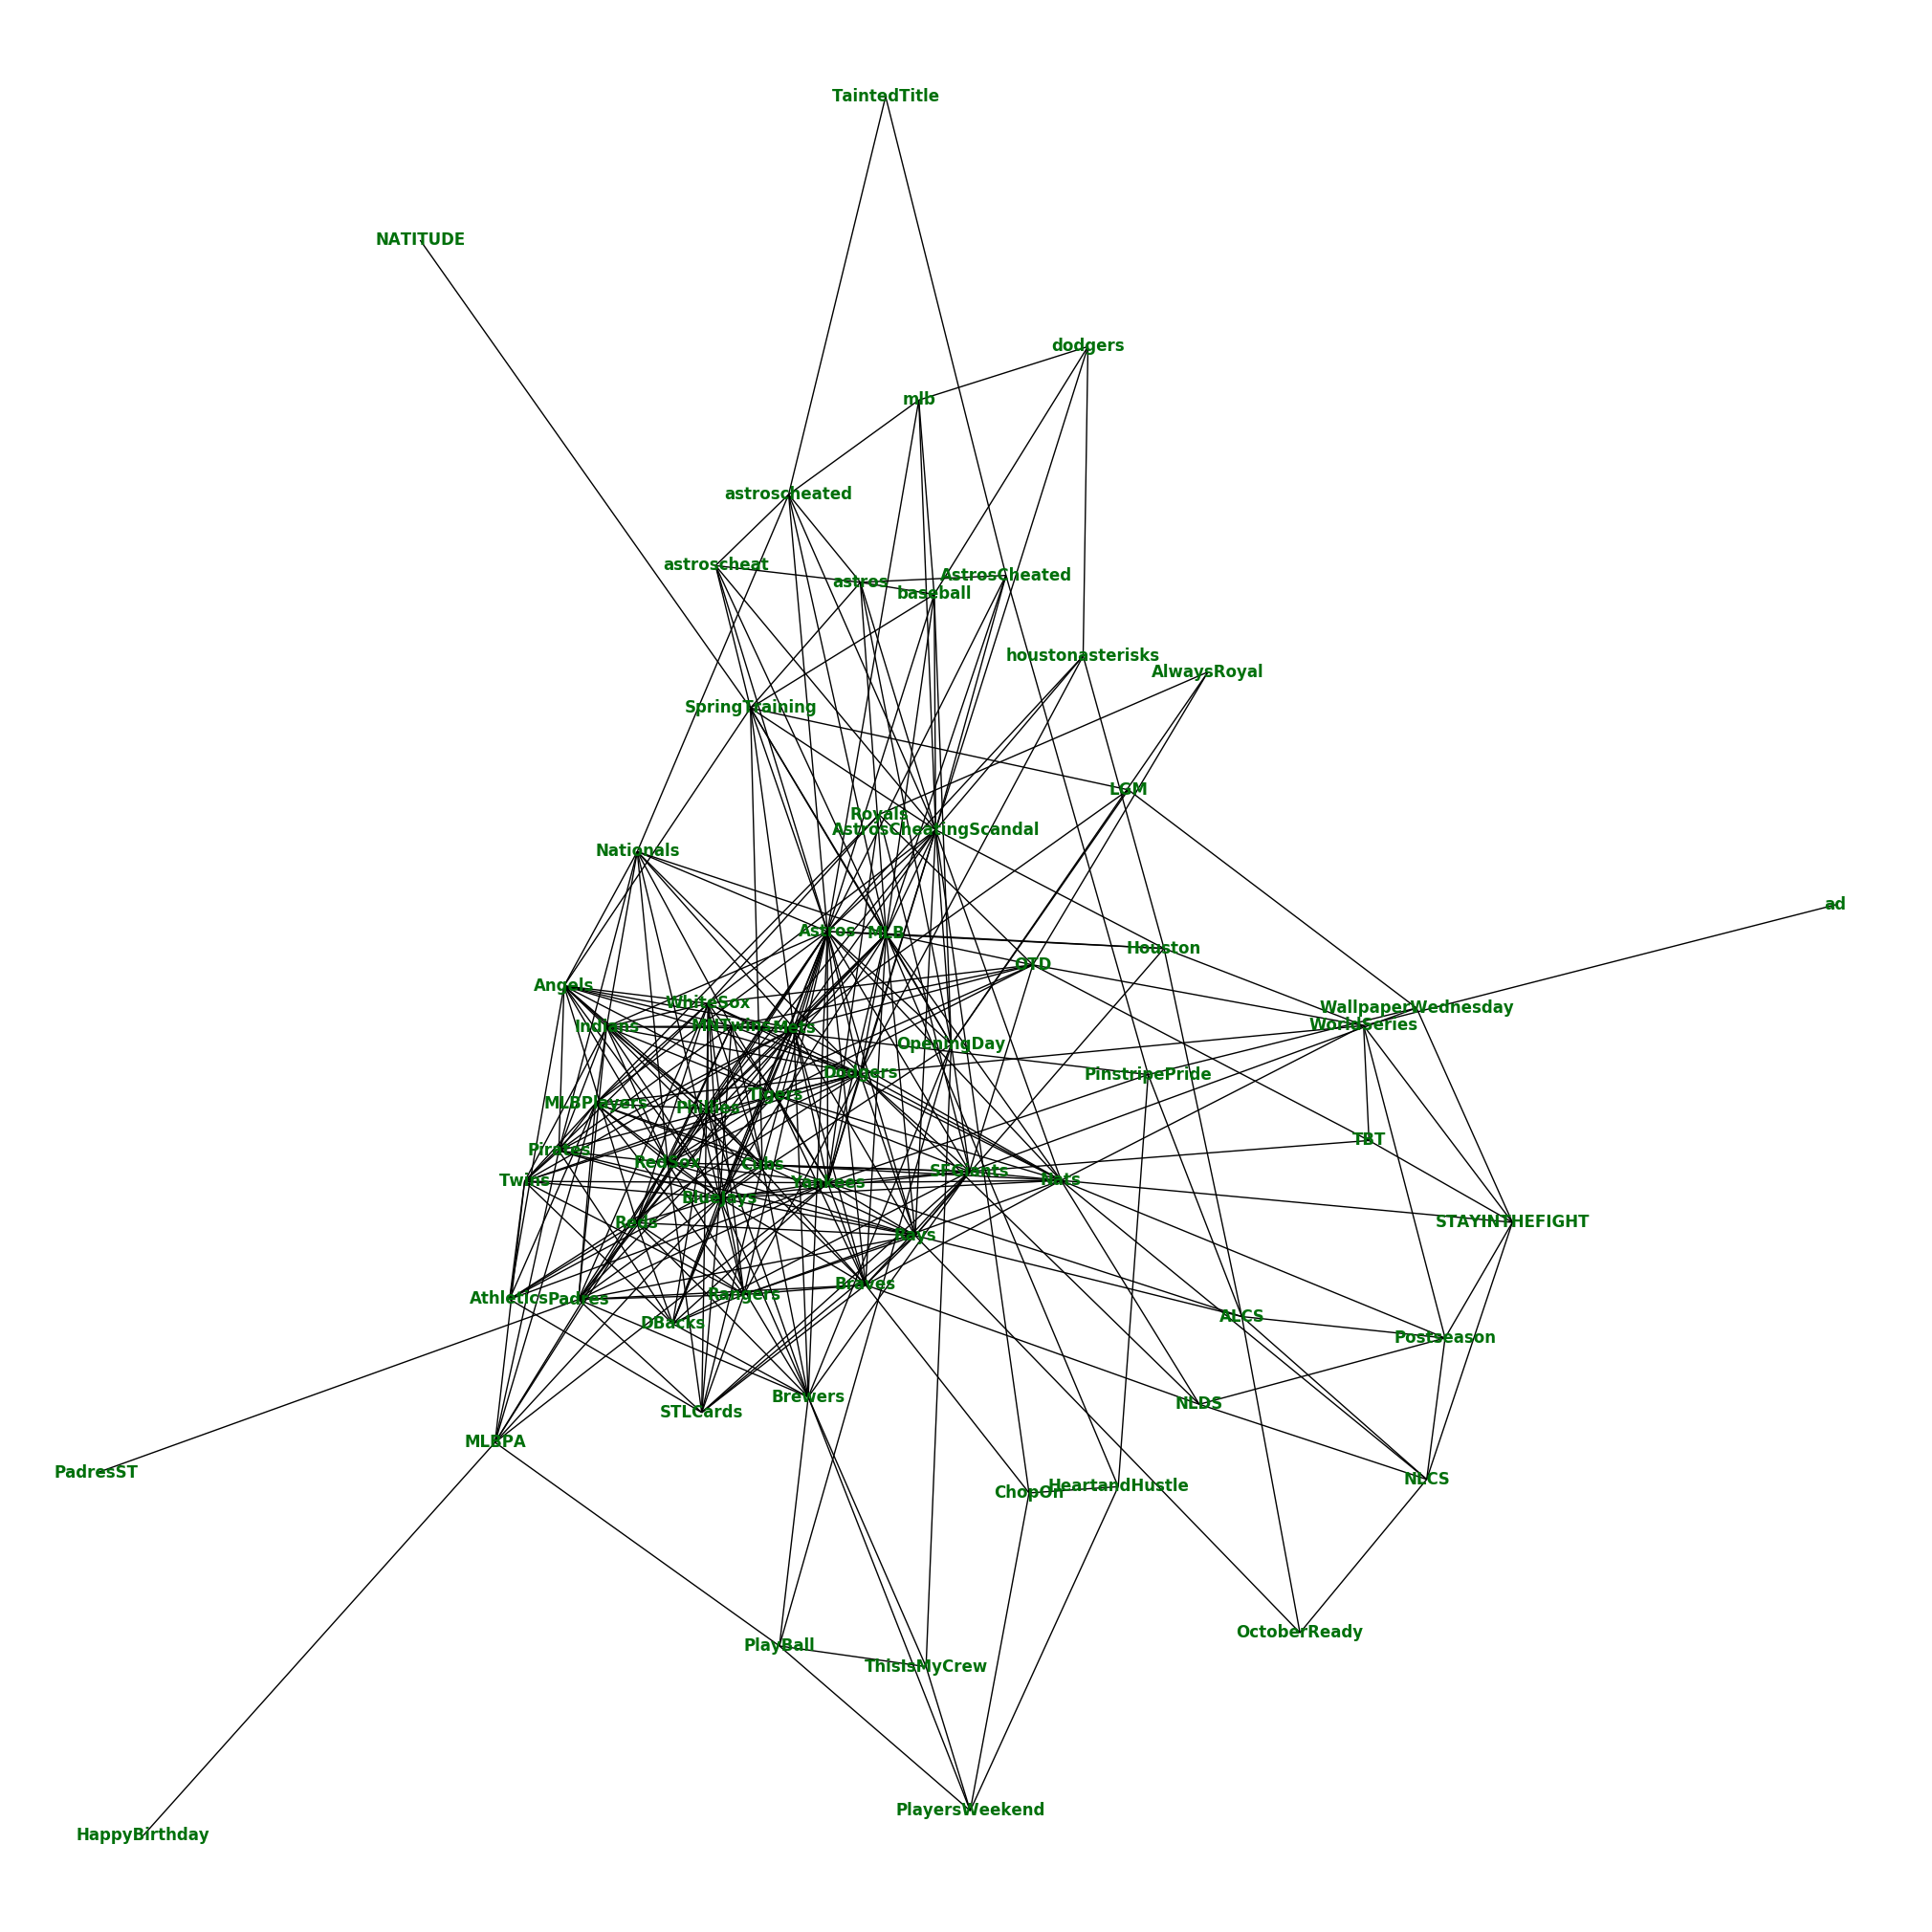

In [132]:
all_tags = build_network_graph(hashtag_connections,10)
show_graph(all_tags,"#00700B")

### Clustrers Hashtag Interaction Graphs

In conjunction with what was done in `get_cluster_user_graphs`, the `conjunction` function does the same thing, but matches and records all hashtags and any and all hashtags that appear in the same group. Below is the hashtag network graph of all hashtags in cluster 9.

In [103]:
# get_cluster_hashtag_graphs: generates hashtag graphs for each cluster created in section 2
# parameters: dictionary of tweets to graph
# return: list of hashtag connection dictionaries for each cluster, 
#         list of hashtag graphs for each cluster
def conjunction(dictionary):
    cluster_connections = []
    cluster_graphs = []
    
    # get all user hashtags for each cluster in dict
    for k,v in dictionary.items():
        connections = get_hashtag_connections(v)
        cluster_connections.append(connections)

    # make network graphs for each hashtag connections dict
    for connection in cluster_connections:
        graph = build_network_graph(connection,3)
        cluster_graphs.append(graph)
    
    return cluster_connections, cluster_graphs
        
hashtag_cluster_connections,hashtag_cluster_graphs=get_cluster_hashtag_graphs(clustered_tweets)

#### Example Graph: Cluster 9 of 20

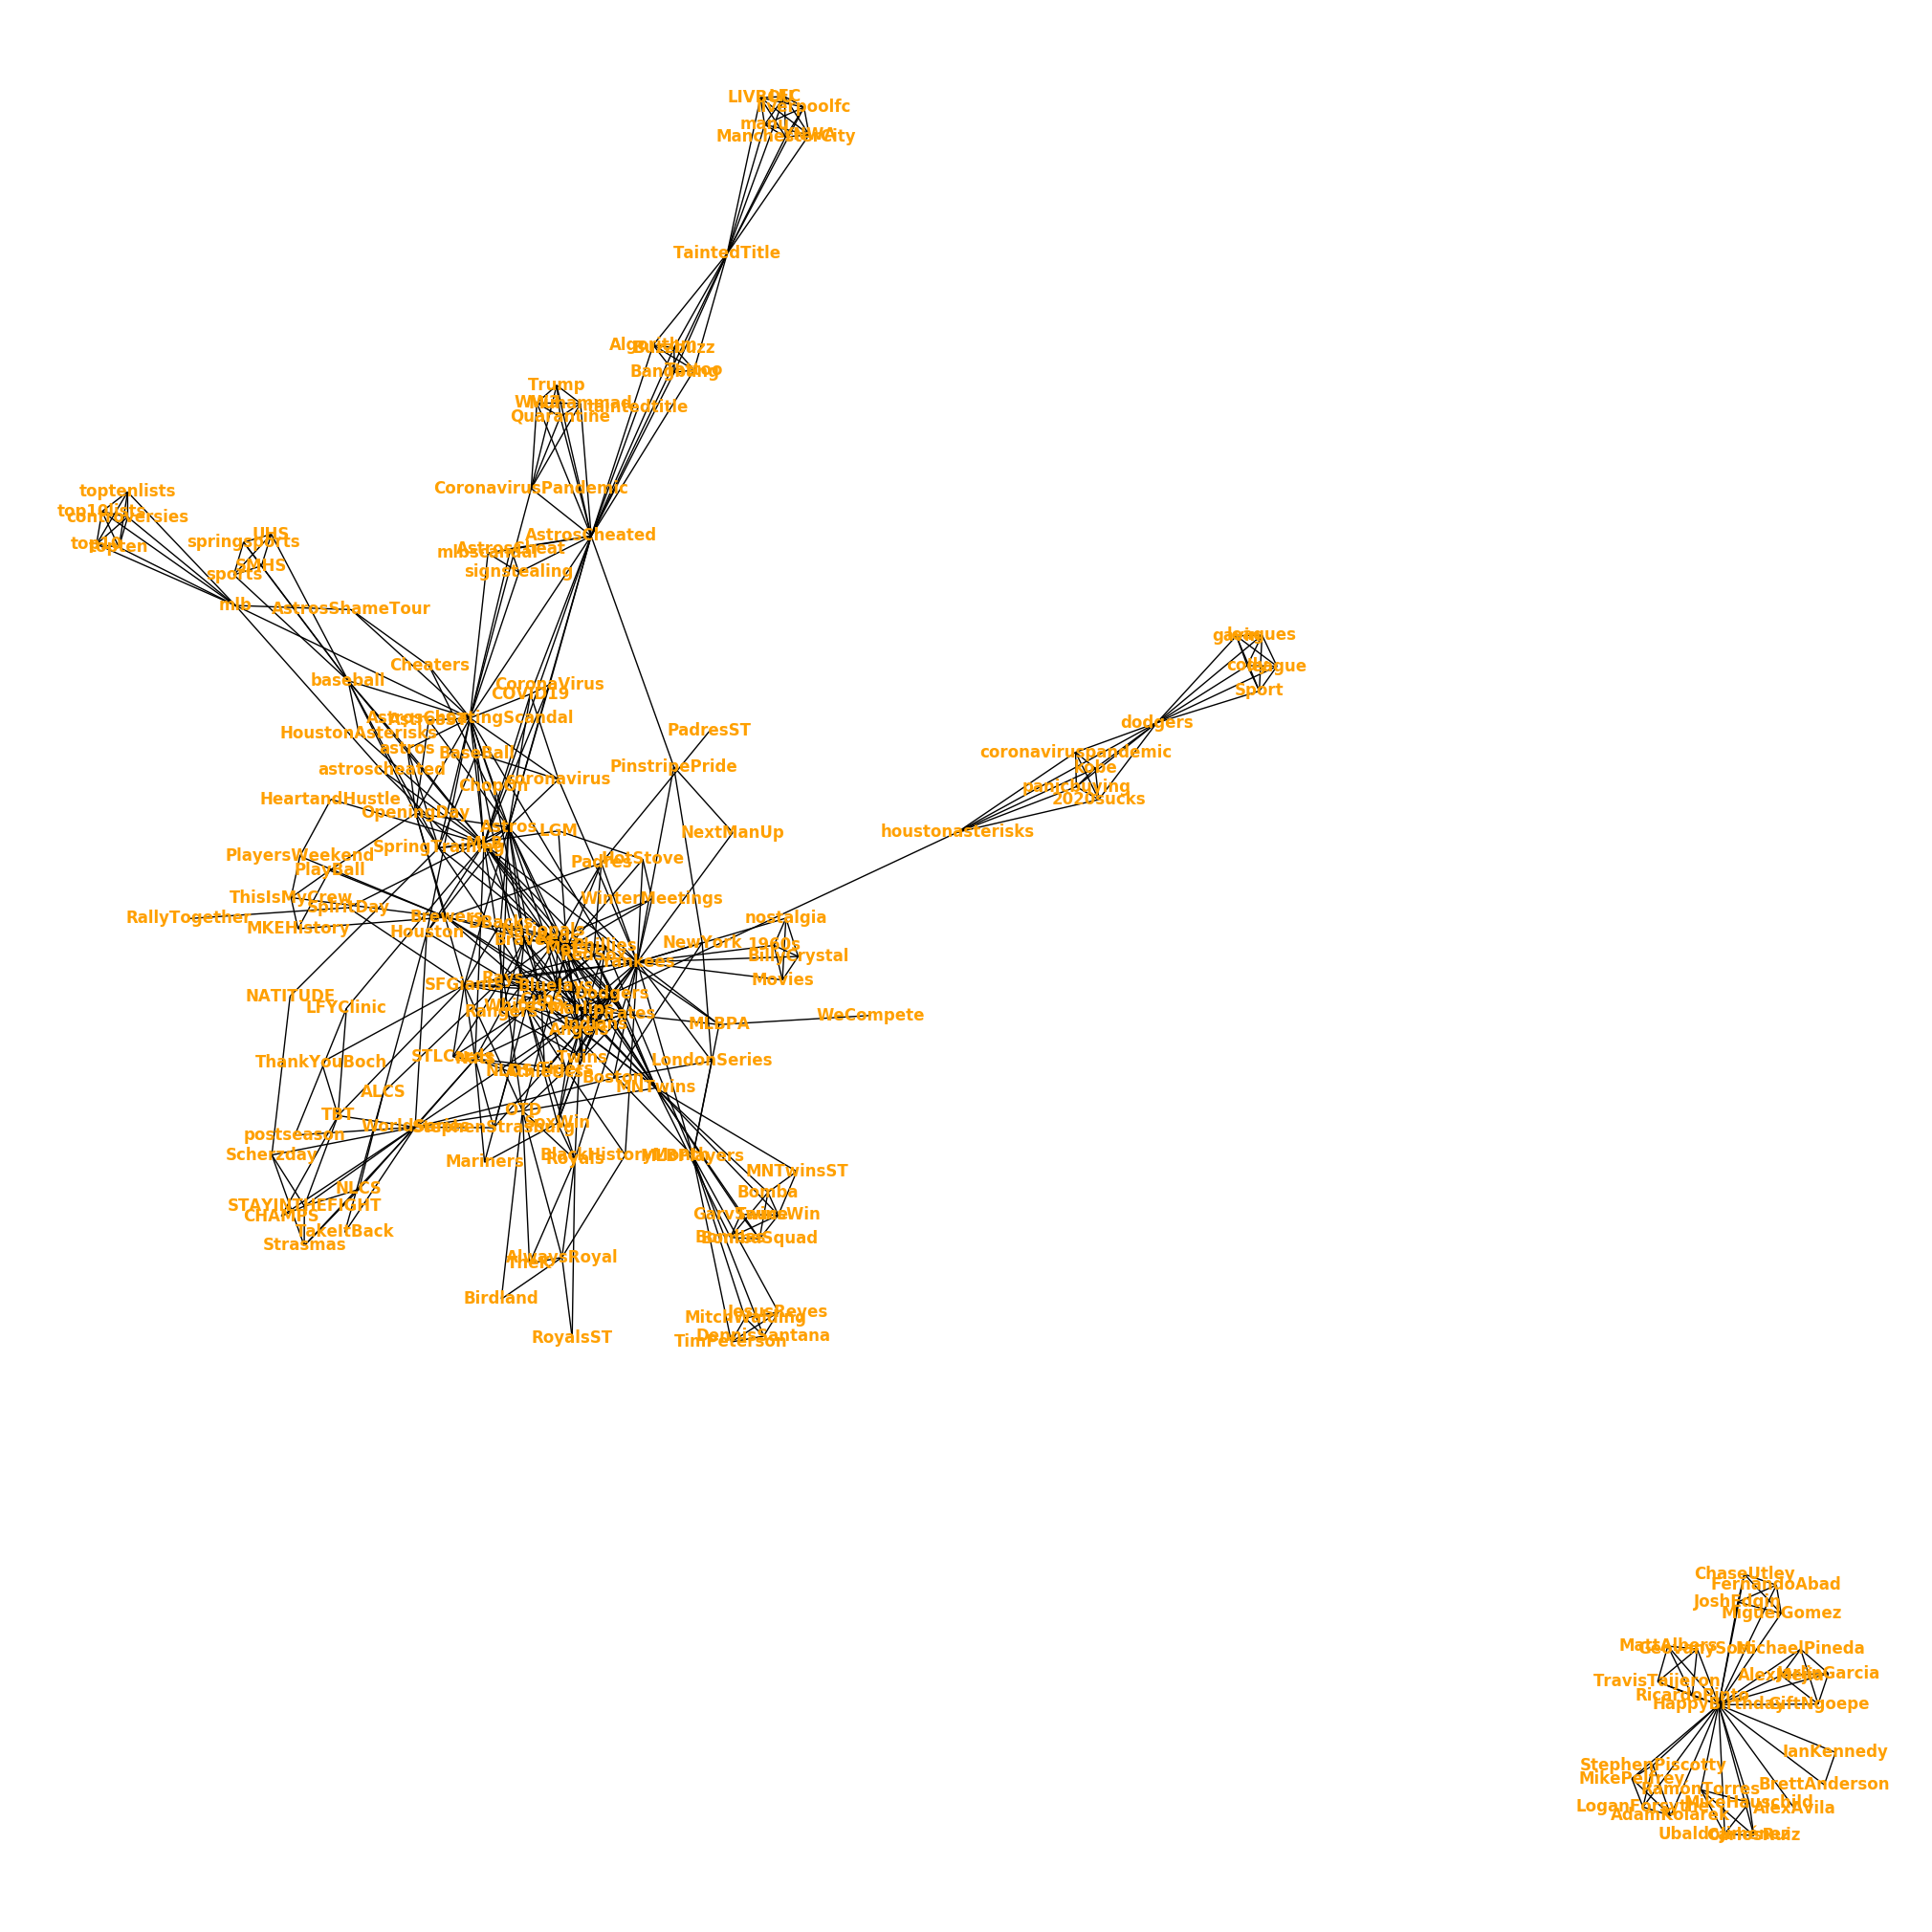

In [148]:
show_graph(hashtag_cluster_graphs[8],"#FFA000")

<a id="analysis"></a>
# Network Analysis

The `get_ties` and `get_triads` functions are used to find ties and triads within a group of connections.

## Ties

`get_ties` takes a connections dictionary and returns a list of all ties within the tweet set. This information is gathered for both the verified connections group and the unverified connections group as well as within each cluster. The first 20 tries or maximum number of tries are then displayed on the console.

As expected, the number of ties in the verified user graph is much larger than the number in the unverified graph. This is because many of the user connections from the verified users graph were acquired by using the REST architecture and it is expected that the accounts searched would be related. It is much less common to find ties among a random set of users as seen in the streamed data.

In [134]:
# get_ties: finds all ties in given connections dict
# parameters: dictionary of connections to search
# return: list of all possible ties within the connections set
def get_ties(connections):
    
    # get all edges in connections dict
    all_edges = get_edges(connections)
    ties = []
    for e in all_edges:
        inverse = [e[1],e[0]]
        
        # if a is connected to b and b is connected to a, 
        # add to list of ties
        if inverse in all_edges:
            ties.append([e,inverse])
    
    return ties

### Users

In [135]:
verified_ties = get_ties(verified)
unverified_ties = get_ties(unverified)

In [138]:
display_ties = 12

# get max amount of ties that can be shown
display_all_ties = min(display_ties,len(verified_ties),len(unverified_ties))

print("{:<50}{:<25}\n".format("All Ties in Verified Users Graph: "+str(len(verified_ties)), 
                            "All Ties in Unverified Users Graph: "+str(len(unverified_ties))))

for v in range(display_all_ties):
    print("{:<50}{:<25}".format(", ".join(verified_ties[v][0]), 
                                ", ".join(unverified_ties[v][0])))
    
print("\n{:<50}{:<25}".format("And "+str(len(verified_ties)-display_all_ties)+" more . . .", 
                            "And "+str(len(unverified_ties)-display_all_ties)+" more . . ."))

all_ties = get_ties(all_user_connections)
print("\nTies Across All Users: ",len(all_ties))

All Ties in Verified Users Graph: 452             All Ties in Unverified Users Graph: 42

Ken_Rosenthal, MarcCarig                          _DanielRz_, aLMa_182     
Ken_Rosenthal, JasonLaCanfora                     214Yankees, JulianGuilarte1
Ken_Rosenthal, MLB                                HeelTrigga, SSFBartender 
Ken_Rosenthal, ctrent                             shsu05, mamba824kb       
Ken_Rosenthal, jonmorosi                          spacecasscain, daredevilIe
Ken_Rosenthal, Buster_ESPN                        aLMa_182, _DanielRz_     
fsnorth, Twins                                    daredevilIe, spacecasscain
ctrent, Ken_Rosenthal                             JulianGuilarte1, 214Yankees
Kantrowitz, jareddiamond                          JulianGuilarte1, bomberbeat2
jareddiamond, Kantrowitz                          mamba824kb, shsu05       
JasonLaCanfora, Ken_Rosenthal                     nlbmprez, ArchaeoPancake 
Reds, Cubs                                        zeke7434, Kovar

### Clusters

In [175]:
# get_cluster_ties: gets information on ties in each cluster
# parameters: number of ties to show
# return: none. stats are printed to console
def get_cluster_ties(display_ties):
    
    # loop to get ties in all clusters
    for cluster in range(0,len(user_cluster_connections),2):
        ties1 = get_ties(user_cluster_connections[cluster])
        ties2 = get_ties(user_cluster_connections[cluster+1])
        
        # get max amount of ties that can be shown
        range_lim = min(display_ties,len(ties1),len(ties2))

        print("{:<50}{:<25}".format("Ties in Cluster "+str(cluster+1)+": "+str(len(ties1)), 
                                    "Ties in Cluster "+str(cluster+2)+": "+str(len(ties2))))
        
        # print info for each cluster
        for v in range(range_lim):
            print("  {:<50}{:<25}".format(", ".join(ties1[v][0]), ", ".join(ties2[v][0])))
            
        print("{:<50}{:<25}\n".format("And "+str(len(ties1)-range_lim)+" more . . .", 
                                      "And "+str(len(ties2)-range_lim)+" more . . ."))
        
get_cluster_ties(display_ties)

Ties in Cluster 1: 20                             Ties in Cluster 2: 76    
  zeke7434, Kovar_HJsports                          HeelTrigga, SSFBartender 
  Kovar_HJsports, zeke7434                          spacecasscain, daredevilIe
  fastballs, cwyers                                 daredevilIe, spacecasscain
  Marlins, tigers                                   JulianGuilarte1, bomberbeat2
  Indians, tigers                                   Ken_Rosenthal, jonmorosi 
  joe_sheehan, ChristinaKahrl                       nlbmprez, ArchaeoPancake 
  Yankees, MLB                                      fsnorth, Twins           
  Nationals, MLB                                    zeke7434, Kovar_HJsports 
  cwyers, fastballs                                 Kovar_HJsports, zeke7434 
  Mets, Noahsyndergaard                             ArchaeoPancake, nlbmprez 
  Dbacks, MLB                                       bomberbeat2, JulianGuilarte1
  tigers, Indians                                   ktvenn

## Triads

`get_triads` takes a network graph and returns a list of all triads within the tweet set. This information is gathered for both the verified connections group and across all user connections as well as within each cluster. The first 20 triads or maximum number of triads are then displayed on the console.

As previously seen with the tries, the number of triads in the verified user graph makes up most of the triads across all tweets and for the same reasons. It is incredibly unlikely to find triads among a random set of users as seen in the streamed data. This is in part why the number of triads in each cluster are so varied.

In [141]:
# get_triads: finds all triads in given connections dict
# parameters: network connections graph to search
# return: list of all possible triads within the connections graph
def get_triads(graph):
    triads = []
    
    # loop through list of all nodes in graph
    for a in list(graph.nodes):
        
        # loop through all neighbors of current node
        for b in graph.neighbors(a):
            
            # find all nodes that are neighbors of both a and b - defines a triad
            for nbs in nx.common_neighbors(graph,a,b):
                triad = sorted([a,b,nbs])
                
                #if triad not already in triads list, add it
                if triad not in triads:
                    triads.append(triad)
    return triads

### Users

In [142]:
verified_triads = get_triads(V_G)

all_users_graph = build_network_graph(all_user_connections)
all_triads = get_triads(all_users_graph)

In [176]:
display_triads = 12

# get max amount of ties that can be shown
display_all_triads = min(display_triads,len(verified_triads),len(all_triads))

print("{:<45}{:<25}\n".format("Closed Triads in Verified Users Graph: "+str(len(verified_triads)), 
                              "Closed Triads in Across All Users Graph: "+str(len(all_triads))))

for v in range(display_all_triads):
    print("{:<45}{:<25}".format(", ".join(verified_triads[v]),", ".join(all_triads[v])))
    
print("\n{:<45}{:<25}".format("And "+str(len(verified_triads)-display_all_triads)+" more . . .", 
                              "And "+str(len(all_triads)-display_all_triads)+" more . . ."))

Closed Triads in Verified Users Graph: 658   Closed Triads in Across All Users Graph: 660

Ken_Rosenthal, MLB, jonmorosi                Ken_Rosenthal, MLB, jonmorosi
Cubs, MLB, Reds                              Cubs, MLB, Reds          
MLB, Reds, Rockies                           MLB, Reds, Rockies       
MLB, Phillies, Reds                          MLB, Phillies, Reds      
MLB, Marlins, Reds                           MLB, Marlins, Reds       
Indians, MLB, Reds                           Indians, MLB, Reds       
Brewers, MLB, Reds                           Brewers, MLB, Reds       
MLB, RaysBaseball, Reds                      MLB, RaysBaseball, Reds  
MLB, Reds, Twins                             MLB, Reds, Twins         
Angels, MLB, Reds                            Angels, MLB, Reds        
MLB, Mets, Reds                              MLB, Mets, Reds          
Dodgers, MLB, Reds                           Dodgers, MLB, Reds       

And 646 more . . .                           And 648

### Clusters

In [174]:
# get_cluster_triads: gets information on triads in each cluster
# parameters: number of triads to show
# return: none. stats are printed to console
def get_cluster_triads(display_ties):
    for cluster in range(0,len(user_cluster_graphs),2):
        triads1 = get_triads(user_cluster_graphs[cluster])
        triads2 = get_triads(user_cluster_graphs[cluster+1])
        
        range_lim = min(display_ties,len(triads1),len(triads2))

        print("{:<50}{:<25}".format("Closed Triads in Cluster "+str(cluster+1)+": "+str(len(triads1)), 
                                    "Closed Triads in Cluster "+str(cluster+2)+": "+str(len(triads2))))
        for v in range(range_lim):
            print("{:<50}{:<25}".format(", ".join(triads1[v]), ", ".join(triads2[v])))
        print("{:<50}{:<25}\n".format("And "+str(len(triads1)-range_lim)+" more . . .", 
                                      "And "+str(len(triads2)-range_lim)+" more . . ."))
        
get_cluster_triads(display_ties)

Closed Triads in Cluster 1: 0                     Closed Triads in Cluster 2: 0
And 0 more . . .                                  And 0 more . . .         

Closed Triads in Cluster 3: 1                     Closed Triads in Cluster 4: 32
Phillies, Reds, Rockies                           Ken_Rosenthal, MLB, jonmorosi
And 0 more . . .                                  And 31 more . . .        

Closed Triads in Cluster 5: 0                     Closed Triads in Cluster 6: 0
And 0 more . . .                                  And 0 more . . .         

Closed Triads in Cluster 7: 0                     Closed Triads in Cluster 8: 0
And 0 more . . .                                  And 0 more . . .         

Closed Triads in Cluster 9: 13                    Closed Triads in Cluster 10: 21
Braves, Reds, SFGiants                            Indians, MLB, Marlins    
Braves, Brewers, Reds                             MLB, Marlins, Nationals  
Brewers, Reds, SFGiants                           MLB, Ma